<a href="https://colab.research.google.com/github/reincarnateMin/pygame_tutorials/blob/master/%ED%83%9C%EC%96%91%EA%B4%91_%EB%B0%9C%EC%A0%84%EB%9F%89_%EC%98%88%EC%B8%A1_%EC%BD%94%EB%93%9C_%EA%B3%B5%EC%9C%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 태양광 발전량 예측하기

DACON 별명 : 수현_KIM(cielo)

### 설명

- **가설설정**

1) 상대습도가 낮을 때, 발전량은 작다. (음의 상관관계)

2) 발전량에는 일사량 관련 칼럼(DHI, DNI)이 많은 영향을 미칠 것이다. (양의 상관관계)

3) 기온이 높으면 태양광 발전량의 크기가 높을 것이다.(양의 상관관계)

4) 풍속은 발전량에 직접적인 영향을 미치기보다는 상대습도와 연관이 높을 것이다.

5) 풍속과 기온을 합한 값은 발전량에 영향이 있을 것이다.



- **칼럼 수정** 
가설 설정에 따라 DHI + DNI(일사량) 합에 대한 칼럼을 추가

가설 설정에 따라 WS + T(WS_T)에 대한 칼럼을 추가


- **모델링**

랜덤포레스트 사용

2회차에 걸친 변수중요도 확인을 통해 WS_T, WS, RH 칼럼 삭제


- **하이퍼 파라미터 수정**

GridSearchCV > 소수의 칼럼에 대해 적합 (**soyeong523님의 코드를 참고했습니다.**)

RandomizedSearchCV > 다수의 칼럼에 대해 적합



# 1. 데이터 불러오기

In [ ]:
# 데이터 처리를 위한 라이브러리
import numpy as np # 수학 계산 함수 > 넘파이
import pandas as pd # 데이터 처리 함수 > 판다스

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# 한글 폰트를 사용하기 위한 코드
plt.rc('font', family='Malgun Gothic')

In [ ]:
train_df = pd.read_csv('data/data/train.csv')
train_df

,ID,DHI,DNI,WS,RH,T,TARGET
0,1,0.315650,0.885087,3.129167,-0.563454,-0.106409,33.659014
1,2,0.075239,0.756084,3.068750,-1.030301,0.317479,20.747731
2,3,0.148714,0.628092,1.547917,-1.190128,0.411156,18.263065
3,4,0.821308,0.283800,3.020833,-0.218049,1.308111,21.072718
4,5,0.174578,0.592866,2.056250,0.286934,-0.312498,16.076963
...,...,...,...,...,...,...,...
725,726,0.501543,0.642224,2.918750,-1.219349,-0.094699,25.604709
726,727,0.082733,0.774102,3.110417,-0.612778,-0.563083,20.438856
727,728,0.587950,0.385512,2.704167,1.294474,0.839727,21.876819
728,729,0.816605,0.195044,1.656250,1.413581,0.811624,17.209349


In [ ]:
test_df = pd.read_csv('data/data/test.csv')
test_df

,ID,DHI,DNI,WS,RH,T
0,1,0.300661,0.500871,4.272917,0.005448,-0.556057
1,2,0.595151,0.761307,4.385417,-1.171177,0.909985
2,3,0.069508,0.535166,1.795833,0.866136,-0.970577
3,4,0.758707,0.406851,3.597917,0.263797,-0.171982
4,5,0.098751,0.772563,2.279167,-0.915363,-0.783224
...,...,...,...,...,...,...
360,361,0.081117,0.524193,2.237500,0.235292,-0.111093
361,362,0.024541,0.657084,1.985417,-0.219885,-2.469406
362,363,0.111242,0.391788,1.212500,1.482526,-1.366362
363,364,0.316091,0.266753,2.681250,0.206974,-0.518587


In [ ]:
submission_df = pd.read_csv('data\data\sample_submission.csv')
submission_df

,ID,TARGET
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
360,361,0
361,362,0
362,363,0
363,364,0


----------------

# 2. 데이터 정보 확인하기

### 1. train 전체 데이터 확인

In [ ]:
# 결측치와 변수 타입 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      730 non-null    int64  
 1   DHI     730 non-null    float64
 2   DNI     730 non-null    float64
 3   WS      730 non-null    float64
 4   RH      730 non-null    float64
 5   T       730 non-null    float64
 6   TARGET  730 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 40.0 KB


In [ ]:
train_df.isnull().sum()

ID        0
DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

위의 코드를 통해 train 데이터에 결측치 확인
- 결측치가 없다.
- 변수의 타입은 정수, 실수형이다.


In [ ]:
# 각 데이터에 대한 통계치 확인
train_df.describe()

,ID,DHI,DNI,WS,RH,T,TARGET
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,0.353680,0.449832,2.456610,-0.015374,0.005201,17.766240
std,210.877136,0.242069,0.238223,0.894079,1.001358,1.005426,7.852125
min,1.000000,0.000000,0.000810,0.897917,-2.269194,-2.628657,1.958976
25%,183.250000,0.145922,0.279639,1.855208,-0.714420,-0.813083,11.296985
50%,365.500000,0.308450,0.444305,2.276042,-0.064874,-0.053716,17.238159
75%,547.750000,0.535709,0.628943,2.855729,0.721717,0.944528,23.586436
max,730.000000,0.983835,1.000000,7.225000,2.867445,1.790547,36.376067


In [ ]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,730.0,365.500000,210.877136,1.000000,183.250000,365.500000,547.750000,730.000000
DHI,730.0,0.353680,0.242069,0.000000,0.145922,0.308450,0.535709,0.983835
DNI,730.0,0.449832,0.238223,0.000810,0.279639,0.444305,0.628943,1.000000
WS,730.0,2.456610,0.894079,0.897917,1.855208,2.276042,2.855729,7.225000
RH,730.0,-0.015374,1.001358,-2.269194,-0.714420,-0.064874,0.721717,2.867445
T,730.0,0.005201,1.005426,-2.628657,-0.813083,-0.053716,0.944528,1.790547
TARGET,730.0,17.766240,7.852125,1.958976,11.296985,17.238159,23.586436,36.376067


위의 코드를 통해 각 데이터의 통계값 확인

ID, TARGET을 제외한 데이터 값들은 모두 전처리가 되어있다.

### 2. train 각 칼럼의 이름 확인

> 칼럼의 이름
- ID : 각 행의 고유한 번호
- DHI : 수평면 산란일사량
- DNI : 법선(수직)면 직달일사량
- WS : 풍속
- RH : 상대습도
- T : 기온
- TARGET:  태양광 발전량, 목표 예측값

> 변수 이름 지정
- feature(X) : 'DHI',	'DNI',	'WS',	'RH',	'T'
- target(Y) : TARGET

위의 feature를 통해 ID에 따른 target을 예측해보도록 하자.

### 3. TARGET(발전량) 데이터 확인

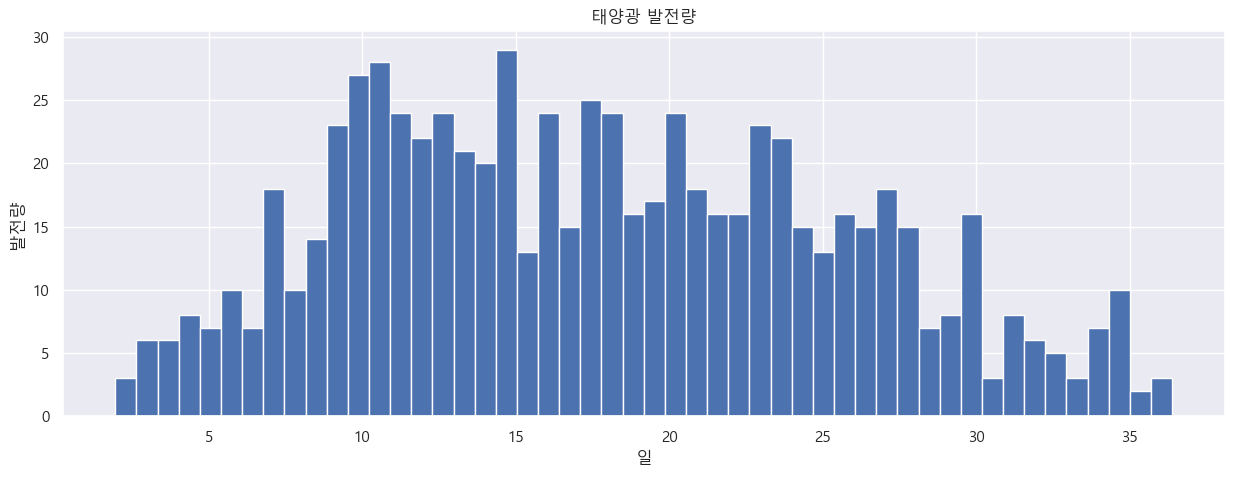

In [ ]:
# 발전량 시각화 - 일에 따른 발전량 분포 확인
plt.figure(figsize=(15, 5))
plt.title("태양광 발전량")
plt.xlabel("일")
plt.ylabel("발전량")
plt.hist(train_df['TARGET'], bins = 50)
plt.show()

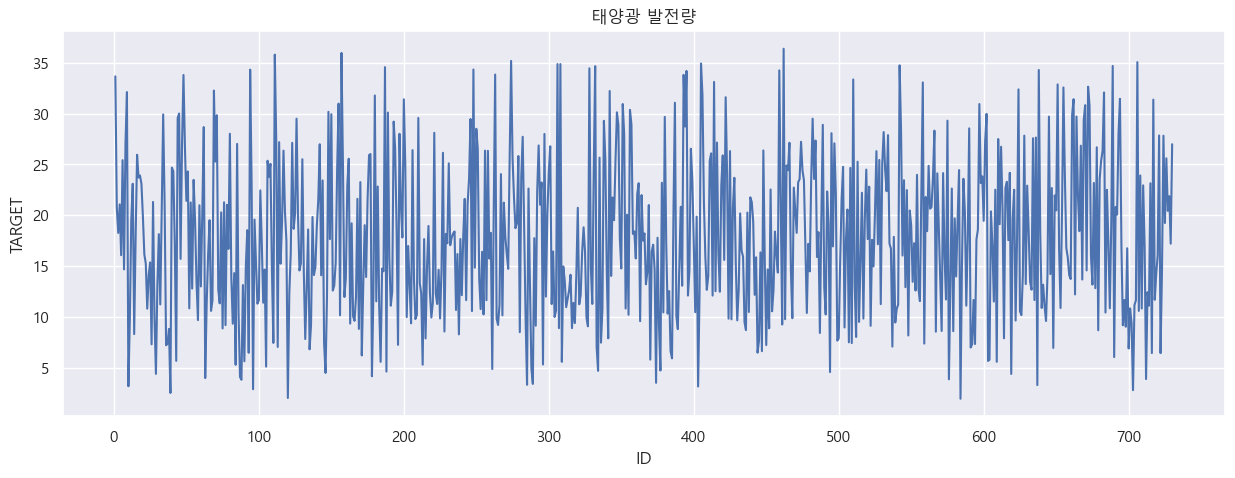

In [ ]:
# 발전량 시각화 - ID에 따른 발전량 추이 확인
plt.figure(figsize=(15, 5))
plt.title("태양광 발전량")
sns.lineplot(train_df, x='ID', y='TARGET')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17364\2384381232.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[feature], ax=ax[0,idx], bins=50)
C:\Users\user\AppData\Local\Temp\ipykernel_17364\2384381232.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[feature], ax=ax[0,idx

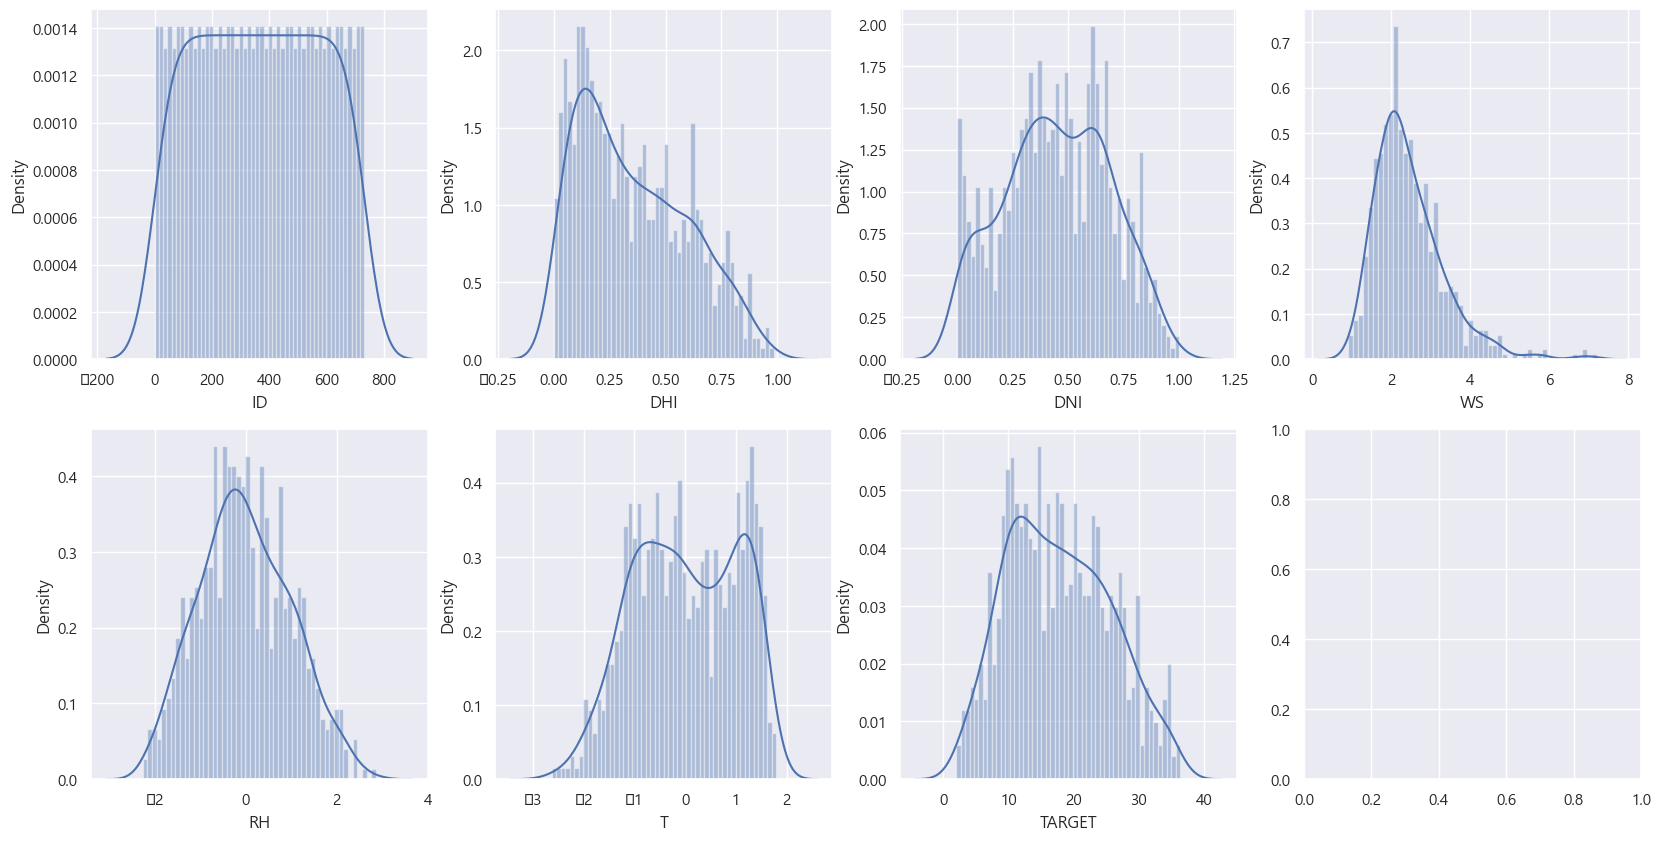

In [ ]:
# 전체 칼럼 시각화 > 전체 칼럼 분포
import seaborn as sns

fig, ax = plt.subplots(2, train_df.shape[1]//2+1, figsize=(20, 10))
for idx, feature in enumerate(train_df.columns):
    if idx<train_df.shape[1]//2+1:
      sns.distplot(train_df[feature], ax=ax[0,idx], bins=50)
    else:
      sns.distplot(train_df[feature], ax=ax[1,idx-train_df.shape[1]//2-1], bins=50)

c:\Users\user\anaconda\envs\dacon\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:>

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


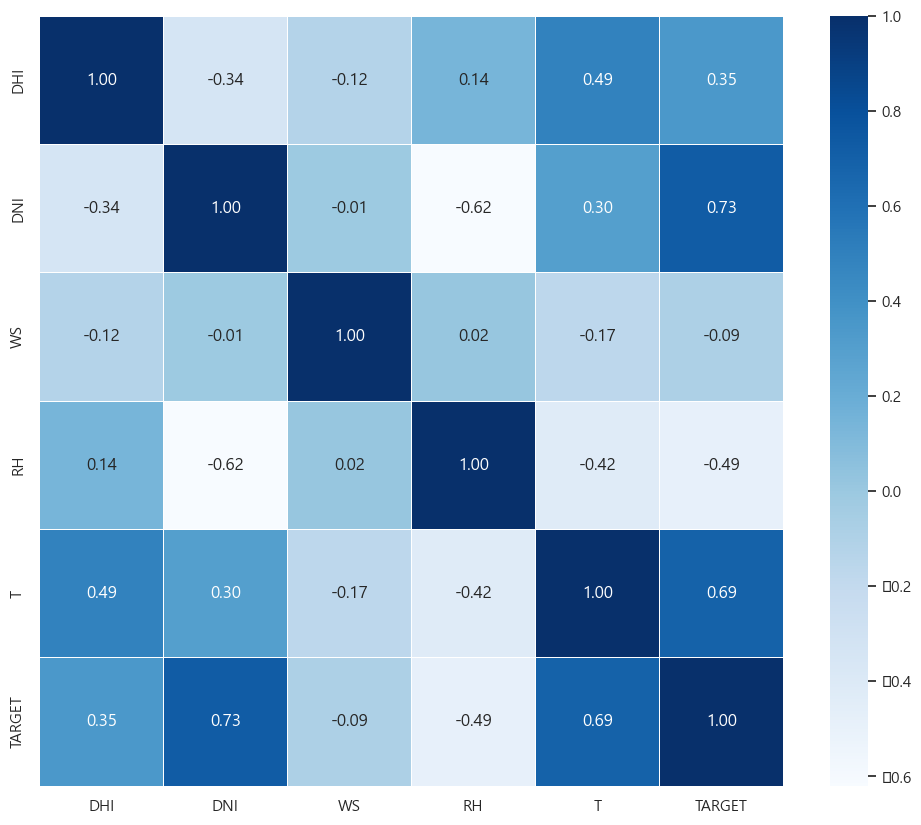

In [ ]:
# 전체 상관관계 확인

plt.figure(figsize=(12,10))
sns.heatmap(data = train_df.drop(['ID'], axis=1).corr(method='pearson'), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

> 상관관계 설명

우리가 예측하고자 하는 TARGET에 대해 DNI = 0.73, T = 0.69, RH = -0.49, DHI = 0.35, WH = -0.09의 상관관계가 높은 순으로 나열할 수 있다.

- 양의 상관관계 : DNI = 0.73, T = 0.69, DHI = 0.35
- 음의 상관관계 : RH = -0.49, WH = -0.09

상관관계의 값이 0에 가까울 수록 선형관계가 약해진다.

----------------------------------

# 3. EDA

- 태양광 발전량이 낮은 날은 "10"을 기준으로 한다.
- 태양광 발전량이 높은 날은 "30"을 기준으로 한다.

In [ ]:
# 태양광 발전량이 낮은 날 "기준 = 10"
train_df.query("TARGET <= 10")

,ID,DHI,DNI,WS,RH,T,TARGET
9,10,0.126084,0.002794,2.487500,1.614283,-1.038493,3.186882
10,11,0.093608,0.418067,2.770833,0.036784,-1.150905,9.812627
13,14,0.151359,0.289671,3.387500,1.221219,-0.710624,8.314666
25,26,0.151212,0.234077,2.483333,0.645005,-0.040835,7.313123
27,28,0.129758,0.358748,4.762500,-0.351503,-0.851139,9.937642
...,...,...,...,...,...,...,...
701,702,0.318001,0.221444,2.816667,0.492833,-1.834746,9.394732
702,703,0.093461,0.006236,2.064583,1.232842,-1.649734,2.803726
711,712,0.164732,0.015427,1.518750,1.905479,-1.101725,3.898500
715,716,0.175018,0.150221,2.581250,0.326673,-0.698915,6.449493


In [ ]:
# 태양광 발전량이 높은 날 "기준 = 30"
train_df.query("TARGET >= 30")

,ID,DHI,DNI,WS,RH,T,TARGET
0,1,0.315650,0.885087,3.129167,-0.563454,-0.106409,33.659014
8,9,0.550184,0.726323,2.354167,-1.545787,1.717947,32.114278
44,45,0.227774,0.825039,2.231250,0.187680,0.436917,30.005610
47,48,0.347686,0.844394,1.985417,-0.030915,0.223802,33.796620
68,69,0.213960,0.876139,2.572917,-0.714210,1.366659,32.262376
93,94,0.305070,0.853302,3.083333,-2.000077,1.497807,34.317704
110,111,0.270830,0.947241,3.145833,-2.013396,0.708579,35.794643
147,148,0.524614,0.735433,1.858333,-1.789200,1.715605,30.175484
154,155,0.732403,0.644046,3.183333,-1.620224,1.528252,30.983083
156,157,0.179280,0.998259,2.641667,-1.693291,1.284692,35.967975


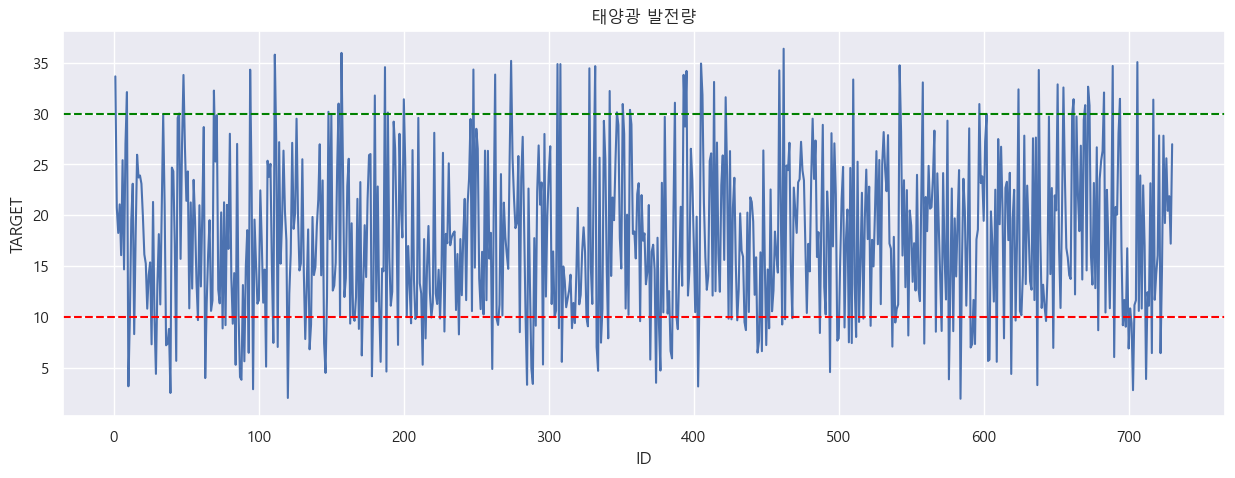

In [ ]:
# 발전량이 낮을 때와 높을 때의 시각화
plt.figure(figsize=(15, 5))
plt.title("태양광 발전량")
g = sns.lineplot(train_df, x='ID', y='TARGET')
g.axhline(10, color='red', linestyle='--')
g.axhline(30, color='green', linestyle='--')
plt.show()

## EDA-1. feature와 target

- feature(X) : 'DHI',	'DNI',	'WS',	'RH',	'T'
- target(Y) : TARGET

### 1) 상대습도와 발전량

가설 : 상대습도가 낮을 때, 발전량은 작다. (음의 상관관계)

1 > 가설이 맞는지 발전량과 상대습도 간의 막대그래프를 그려 확인한다.

In [ ]:
# RH평균과 발전량 기준 10에 대해 표로 확인
TARGET_RH = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 10, '> 10', '<= 10'))
          .groupby('발전량') 
          .agg(상대습도_평균 = ('RH', 'mean'))
          .reset_index()
          )

TARGET_RH.head()

,발전량,상대습도_평균
0,<= 10,0.822989
1,> 10,-0.200431


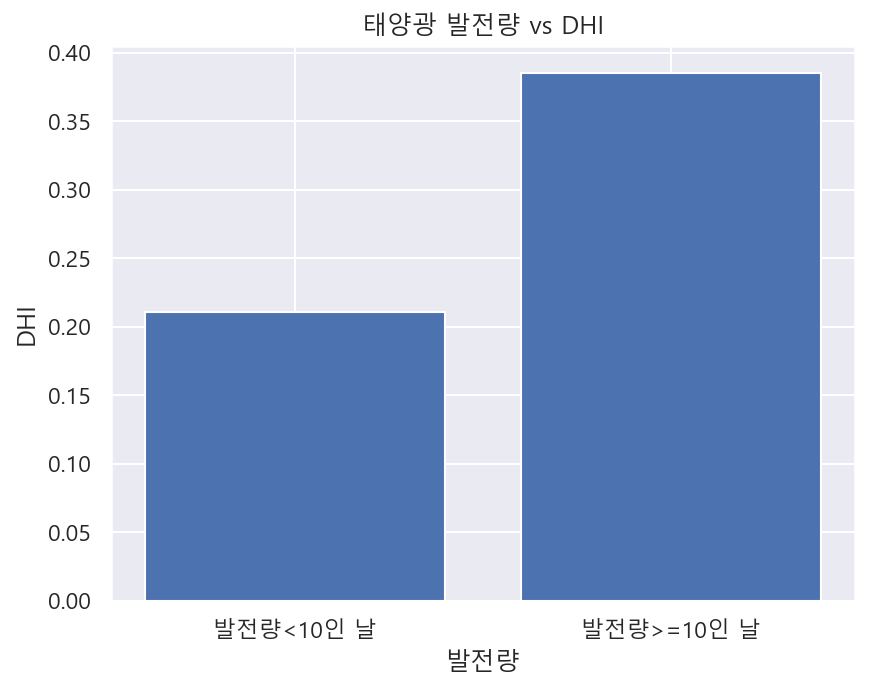

In [ ]:
x = ['발전량<10인 날', '발전량>=10인 날']
y = [train_df[train_df['TARGET'] < 10]['DHI'].mean(), train_df[train_df['TARGET'] >= 10]['DHI'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs DHI")
plt.xlabel('발전량')
plt.ylabel('DHI')
plt.bar(x, y)
plt.show()

In [ ]:
# RH평균과 발전량 기준 30에 대해 표로 확인
TARGET_RH = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 30, '> 30', '<= 30'))
          .groupby('발전량') 
          .agg(상대습도_평균 = ('RH', 'mean'))
          .reset_index()
          )

TARGET_RH.head()

,발전량,상대습도_평균
0,<= 30,0.047843
1,> 30,-0.857021


c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


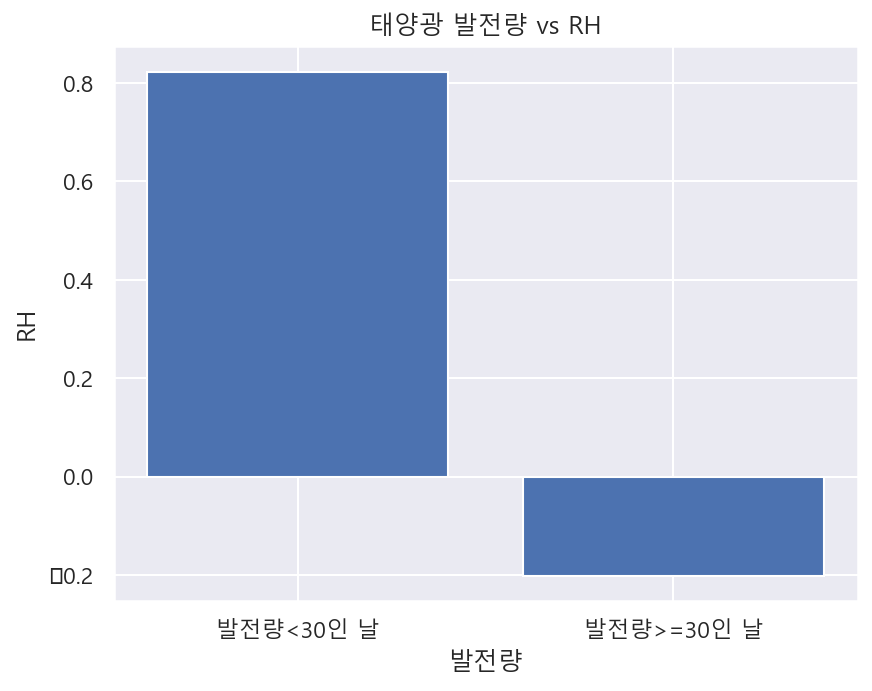

In [ ]:
x = ['발전량<30인 날', '발전량>=30인 날']
y = [train_df[train_df['TARGET'] < 10]['RH'].mean(), train_df[train_df['TARGET'] >= 10]['RH'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs RH")
plt.xlabel('발전량')
plt.ylabel('RH')
plt.bar(x, y)
plt.show()

2 > 상대습도와 발전량 간의 상관관계를 확인한다.

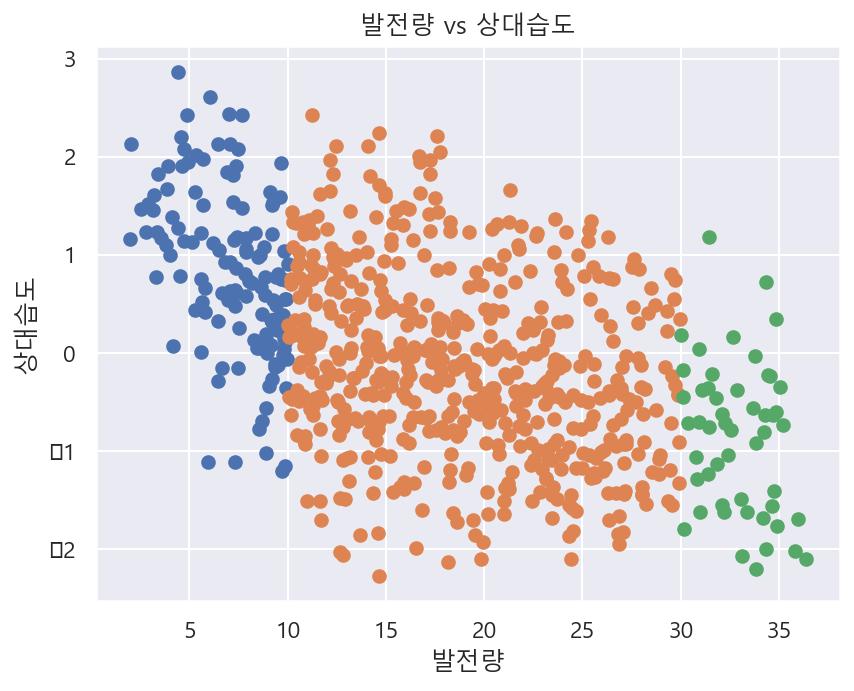

In [ ]:
# 태양광 발전량이 10미만인 날
x_0 = train_df.loc[train_df['TARGET']<10, 'TARGET']
y_0 = train_df.loc[train_df['TARGET']<10, 'RH']

# 태양광 발전량이 10이상 30미만인 날
x_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'TARGET']
y_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'RH']

# 태양광 발전량이 30이상인 날
x_2 = train_df.loc[train_df['TARGET']>=30, 'TARGET']
y_2 = train_df.loc[train_df['TARGET']>=30, 'RH']


# scatter 산점도 그래프 그리기
plt.figure(dpi=150) 

plt.title('발전량 vs 상대습도')
plt.xlabel('발전량')
plt.ylabel('상대습도')

plt.scatter(x_0, y_0)
plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

plt.show()

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


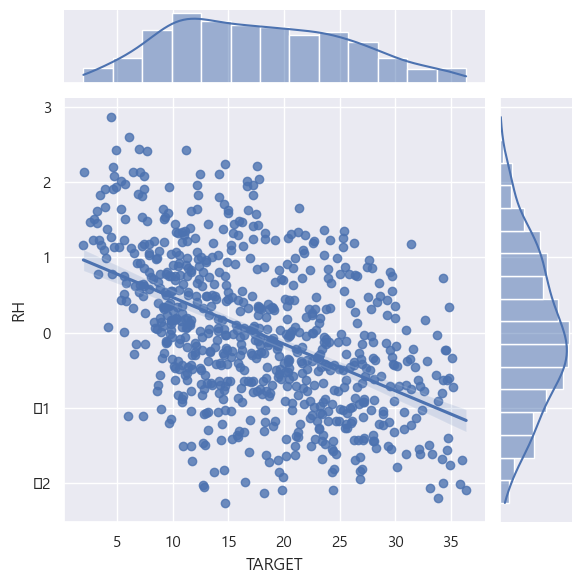

<Figure size 3000x3000 with 0 Axes>

In [ ]:
g = sns.jointplot(train_df, x='TARGET', y='RH',
                  kind='reg')
plt.figure(figsize=(30,30))
plt.show()

> 정리

막대그래프와 산점도 그래프를 통해 발전량과 상대습도는 반비례 관계임을 확인할 수 있다.

따라서, 가설이 맞다.

### 2) 일사량과 발전량

가설 > 발전량에는 일사량 관련 칼럼(DHI, DNI)이 많은 영향을 미칠 것이다. (양의 상관관계)

>> DHI(수평면 산란일사량)과 TRAGET(발전량)

In [ ]:
# DHI평균과 발전량 기준 10에 대해 표로 확인
TARGET_DHI = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 10, '> 10', '<= 10'))
          .groupby('발전량') 
          .agg(DHI_평균 = ('DHI', 'mean'))
          .reset_index()
          )

TARGET_DHI

,발전량,DHI_평균
0,<= 10,0.210862
1,> 10,0.385205


In [ ]:
# 일사량 평균과 발전량 기준 30에 대해 표로 확인
TARGET_DHI = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 30, '> 30', '<= 30'))
          .groupby('발전량') 
          .agg(DNI_평균 = ('DNI', 'mean'))
          .reset_index()
          )

TARGET_DHI

,발전량,DNI_평균
0,<= 30,0.421287
1,> 30,0.829879


1 > 가설이 맞는지 발전량과 DHI 간의 막대그래프를 그려 확인한다.

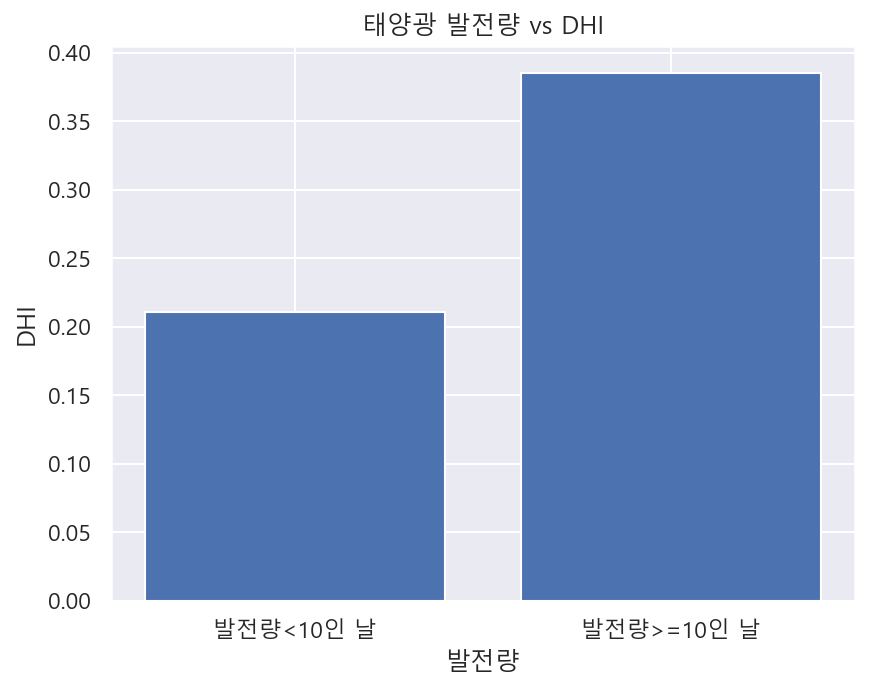

In [ ]:
# 태양광 발전량이 10미만인 날과 10이상인 날의 DHI 평균 비교
x = ['발전량<10인 날', '발전량>=10인 날']
y = [train_df[train_df['TARGET'] < 10]['DHI'].mean(), train_df[train_df['TARGET'] >= 10]['DHI'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs DHI")
plt.xlabel('발전량')
plt.ylabel('DHI')
plt.bar(x, y)
plt.show()

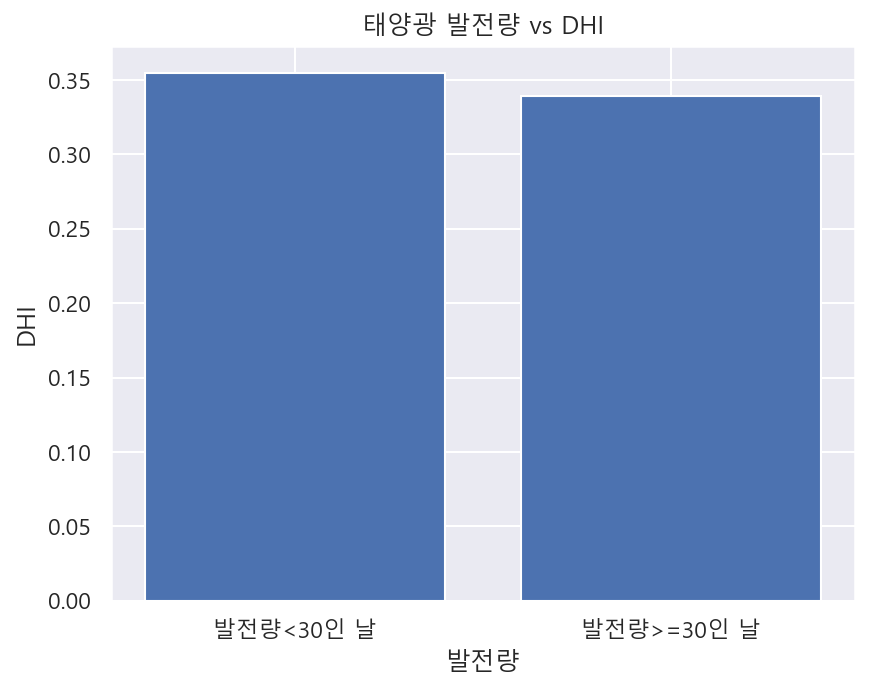

In [ ]:
# 태양광 발전량이 30미만인 날과 30이상인 날의 DHI 평균 비교
x = ['발전량<30인 날', '발전량>=30인 날']
y = [train_df[train_df['TARGET'] < 30]['DHI'].mean(), train_df[train_df['TARGET'] >= 30]['DHI'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs DHI")
plt.xlabel('발전량')
plt.ylabel('DHI')
plt.bar(x, y)
plt.show()

2 > DHI와 발전량 간의 상관관계를 확인한다.

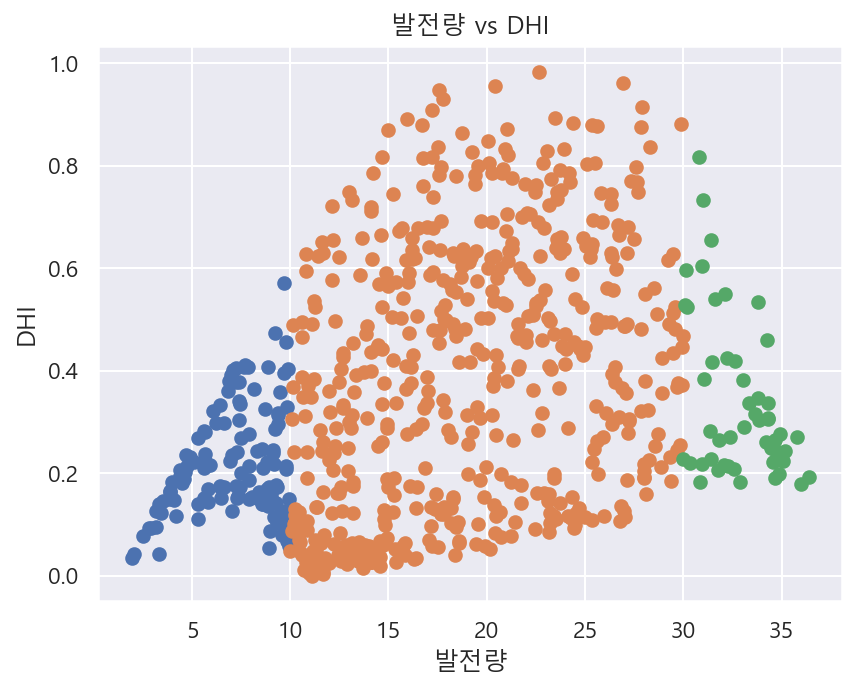

In [ ]:
# 태양광 발전량이 10미만인 날
x_0 = train_df.loc[train_df['TARGET']<10, 'TARGET']
y_0 = train_df.loc[train_df['TARGET']<10, 'DHI']

# 태양광 발전량이 10이상 30미만인 날
x_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'TARGET']
y_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'DHI']

# 태양광 발전량이 30이상인 날
x_2 = train_df.loc[train_df['TARGET']>=30, 'TARGET']
y_2 = train_df.loc[train_df['TARGET']>=30, 'DHI']


# scatter 산점도 그래프 그리기
plt.figure(dpi=150) 

plt.title('발전량 vs DHI')
plt.xlabel('발전량')
plt.ylabel('DHI')

plt.scatter(x_0, y_0)
plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

plt.show()

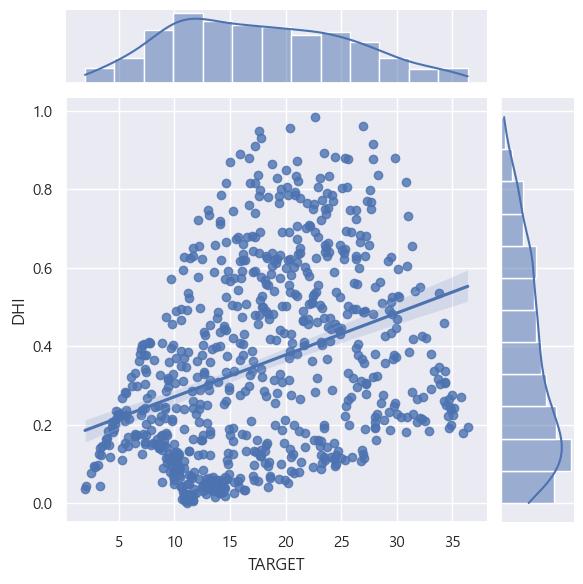

<Figure size 3000x3000 with 0 Axes>

In [ ]:
g = sns.jointplot(train_df, x='TARGET', y='DHI',
                  kind='reg')
plt.figure(figsize=(30,30))
plt.show()

>> DNI(법선면 직달일사량)과 발전량

In [ ]:
# DNI평균과 발전량 기준 10에 대해 표로 확인
TARGET_DNI = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 10, '> 10', '<= 10'))
          .groupby('발전량') 
          .agg(DNI_평균 = ('DNI', 'mean'))
          .reset_index()
          )

TARGET_DNI

,발전량,DNI_평균
0,<= 10,0.176334
1,> 10,0.510203


In [ ]:
# DNI 평균과 발전량 기준 30에 대해 표로 확인
TARGET_DNI = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 30, '> 30', '<= 30'))
          .groupby('발전량') 
          .agg(DNI_평균 = ('DNI', 'mean'))
          .reset_index()
          )

TARGET_DNI

,발전량,DNI_평균
0,<= 30,0.421287
1,> 30,0.829879


1 > 가설이 맞는지 발전량과 DNI 간의 막대그래프를 그려 확인한다.

<BarContainer object of 2 artists>

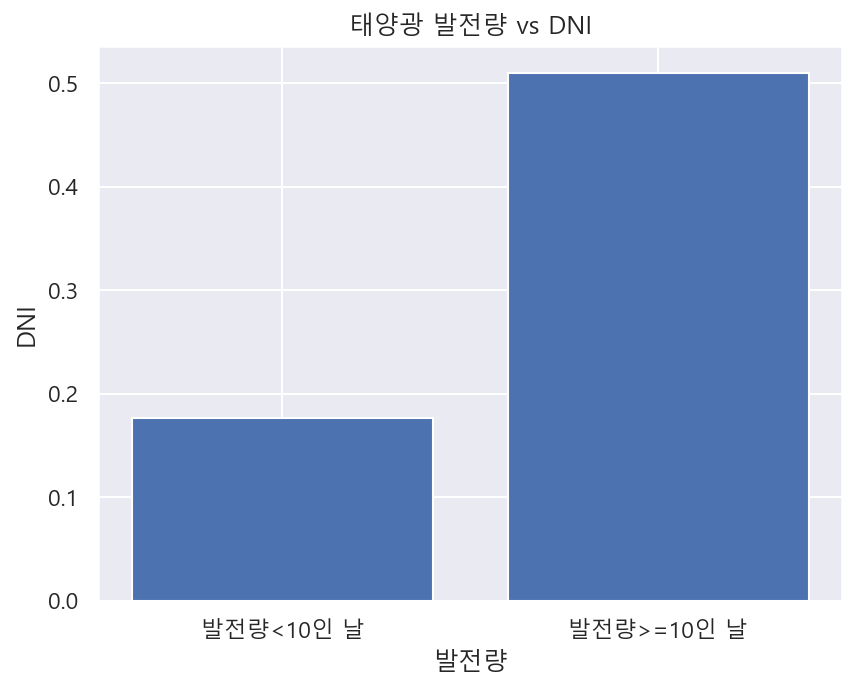

In [ ]:
# 태양광 발전량이 10미만인 날과 10이상인 날의 DNI 평균 비교
x = ['발전량<10인 날', '발전량>=10인 날']
y = [train_df[train_df['TARGET'] < 10]['DNI'].mean(), train_df[train_df['TARGET'] >= 10]['DNI'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs DNI")
plt.xlabel('발전량')
plt.ylabel('DNI')
plt.bar(x, y)

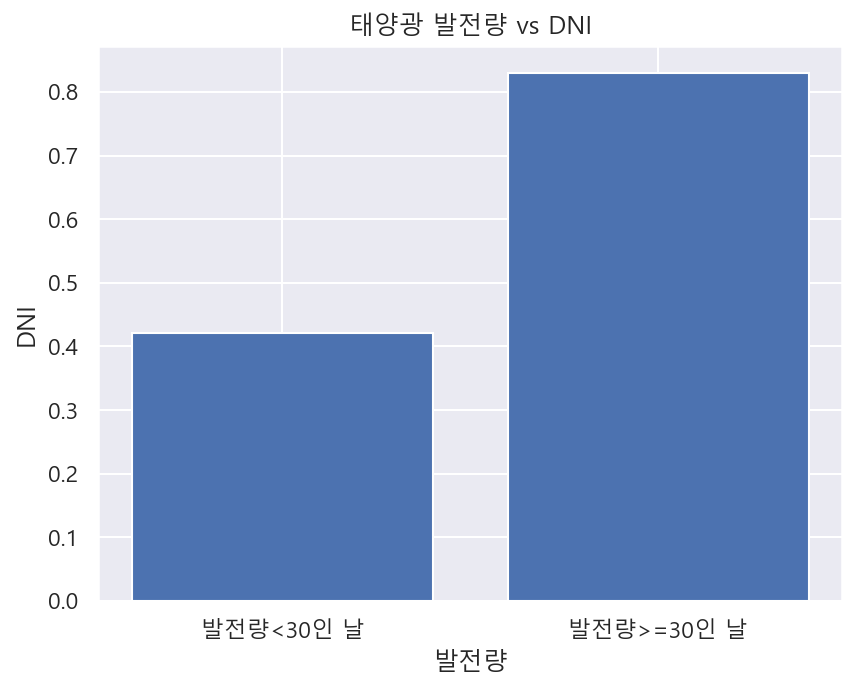

In [ ]:
# 태양광 발전량이 30미만인 날과 30이상인 날의 DHI 평균 비교
x = ['발전량<30인 날', '발전량>=30인 날']
y = [train_df[train_df['TARGET'] < 30]['DNI'].mean(), train_df[train_df['TARGET'] >= 30]['DNI'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs DNI")
plt.xlabel('발전량')
plt.ylabel('DNI')
plt.bar(x, y)
plt.show()

2 > DNI와 발전량 간의 상관관계를 확인한다.

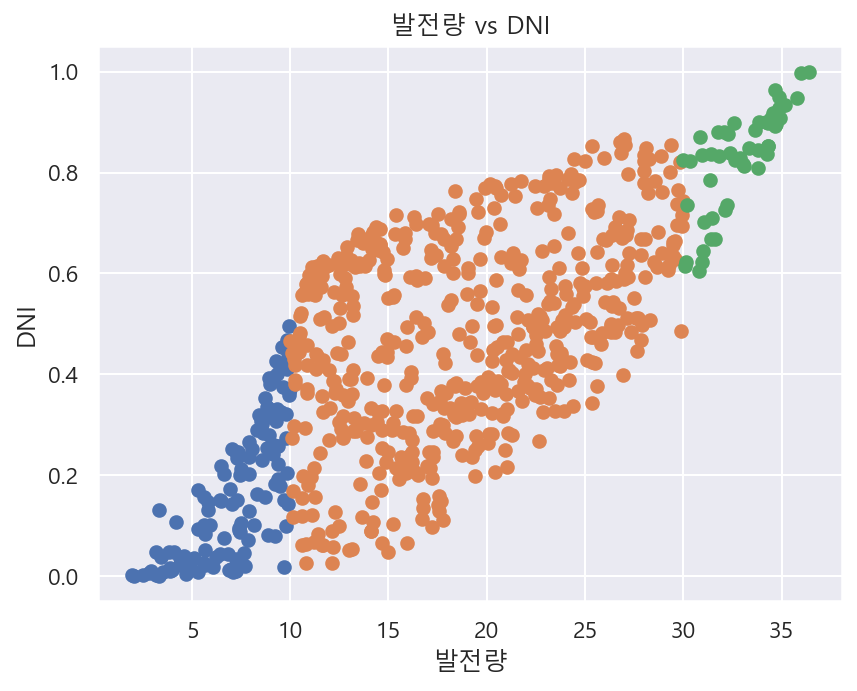

In [ ]:
# 태양광 발전량이 10미만인 날
x_0 = train_df.loc[train_df['TARGET']<10, 'TARGET']
y_0 = train_df.loc[train_df['TARGET']<10, 'DNI']

# 태양광 발전량이 10이상 30미만인 날
x_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'TARGET']
y_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'DNI']

# 태양광 발전량이 30이상인 날
x_2 = train_df.loc[train_df['TARGET']>=30, 'TARGET']
y_2 = train_df.loc[train_df['TARGET']>=30, 'DNI']


# scatter 산점도 그래프 그리기
plt.figure(dpi=150) 

plt.title('발전량 vs DNI')
plt.xlabel('발전량')
plt.ylabel('DNI')

plt.scatter(x_0, y_0)
plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

plt.show()

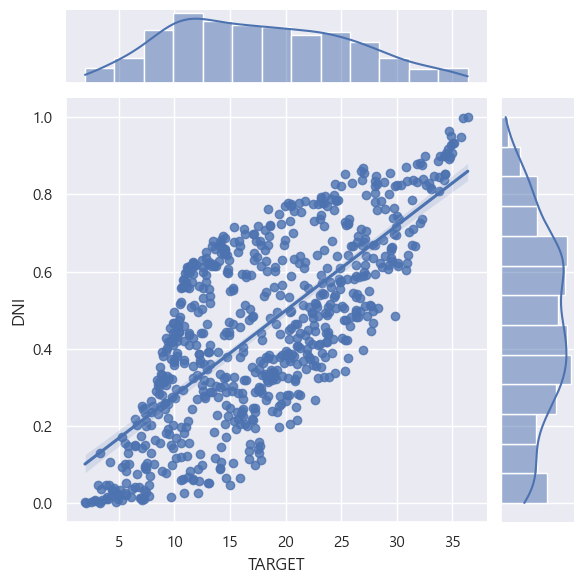

<Figure size 3000x3000 with 0 Axes>

In [ ]:
g = sns.jointplot(train_df, x='TARGET', y='DNI',
                  kind='reg')
plt.figure(figsize=(30,30))
plt.show()

> 정리

막대그래프와 산점도 그래프를 통해 발전량은 DHI, DNI 각각에 대해 비례 관계임을 확인할 수 있다.

>> DNI와 DHI 합과 발전량

In [ ]:
# 일사량 합에 대한 칼럼을 train에 할당
train_df = (train_df
    .assign(일사량 = lambda df: df['DHI'] + df['DNI'])
)

train_df

,ID,DHI,DNI,WS,RH,T,TARGET,일사량
0,1,0.315650,0.885087,3.129167,-0.563454,-0.106409,33.659014,1.200738
1,2,0.075239,0.756084,3.068750,-1.030301,0.317479,20.747731,0.831323
2,3,0.148714,0.628092,1.547917,-1.190128,0.411156,18.263065,0.776807
3,4,0.821308,0.283800,3.020833,-0.218049,1.308111,21.072718,1.105108
4,5,0.174578,0.592866,2.056250,0.286934,-0.312498,16.076963,0.767443
...,...,...,...,...,...,...,...,...
725,726,0.501543,0.642224,2.918750,-1.219349,-0.094699,25.604709,1.143767
726,727,0.082733,0.774102,3.110417,-0.612778,-0.563083,20.438856,0.856835
727,728,0.587950,0.385512,2.704167,1.294474,0.839727,21.876819,0.973462
728,729,0.816605,0.195044,1.656250,1.413581,0.811624,17.209349,1.011649


In [ ]:
# 일사량 평균과 발전량 기준 10에 대해 표로 확인
TARGET_일사량 = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 10, '> 10', '<= 10'))
          .groupby('발전량') 
          .agg(일사량_평균 = ('일사량', 'mean'))
          .reset_index()
          )

TARGET_일사량

,발전량,일사량_평균
0,<= 10,0.387196
1,> 10,0.895408


In [ ]:
# 일사량 평균과 발전량 기준 30에 대해 표로 확인
TARGET_일사량 = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 30, '> 30', '<= 30'))
          .groupby('발전량') 
          .agg(일사량_평균 = ('일사량', 'mean'))
          .reset_index()
          )

TARGET_일사량

,발전량,일사량_평균
0,<= 30,0.776068
1,> 30,1.168888


1 > 가설이 맞는지 발전량과 일사량 간의 막대그래프를 그려 확인한다.

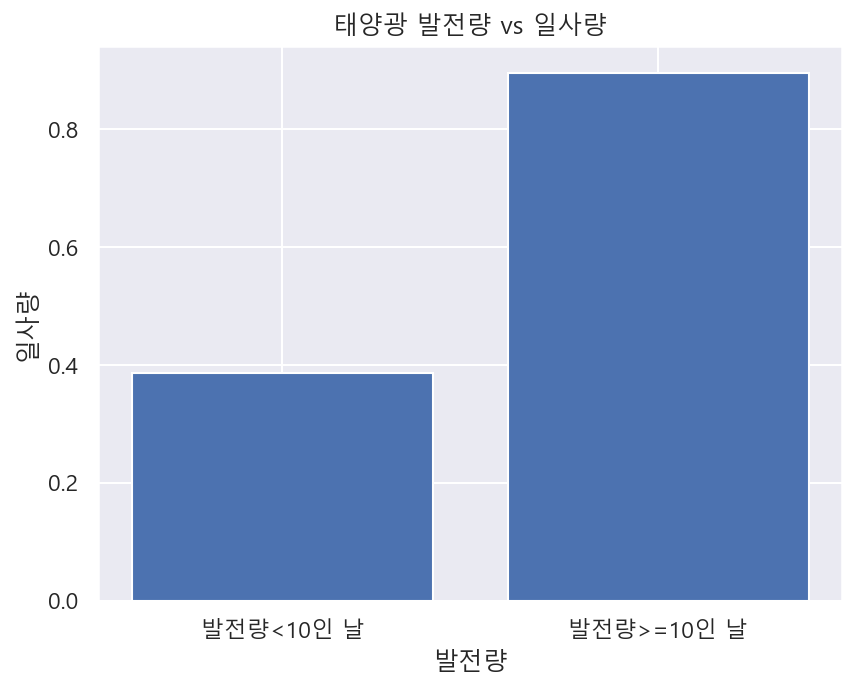

In [ ]:
# 태양광 발전량이 10미만인 날과 10이상인 날의 일사량 평균 비교
x = ['발전량<10인 날', '발전량>=10인 날']
y = [train_df[train_df['TARGET'] < 10]['일사량'].mean(), train_df[train_df['TARGET'] >= 10]['일사량'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs 일사량")
plt.xlabel('발전량')
plt.ylabel('일사량')
plt.bar(x, y)
plt.show()

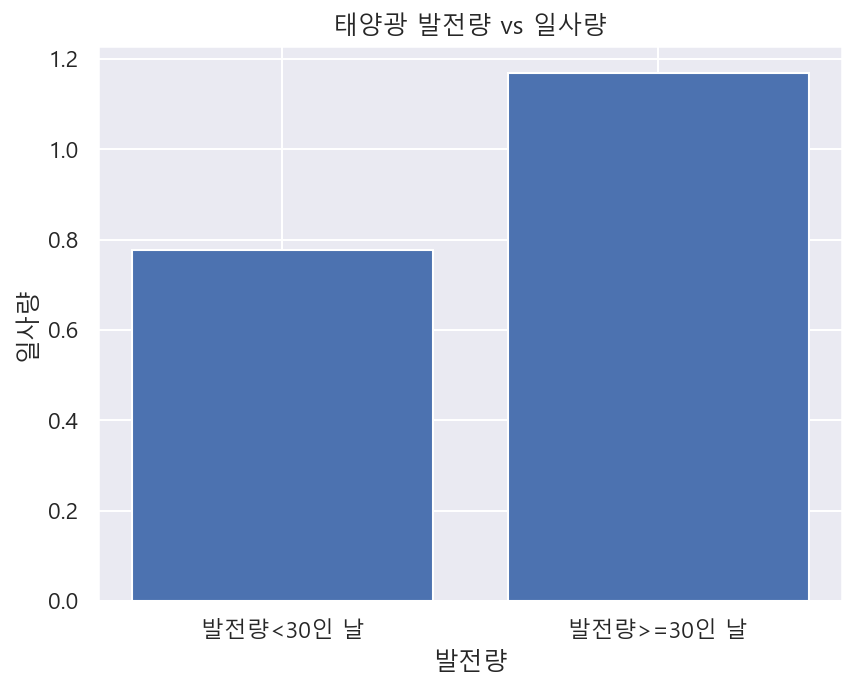

In [ ]:
# 태양광 발전량이 30미만인 날과 30이상인 날의 일사량 평균 비교
x = ['발전량<30인 날', '발전량>=30인 날']
y = [train_df[train_df['TARGET'] < 30]['일사량'].mean(), train_df[train_df['TARGET'] >= 30]['일사량'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs 일사량")
plt.xlabel('발전량')
plt.ylabel('일사량')
plt.bar(x, y)
plt.show()

2 > 일사량과 발전량 간의 상관관계를 확인한다.

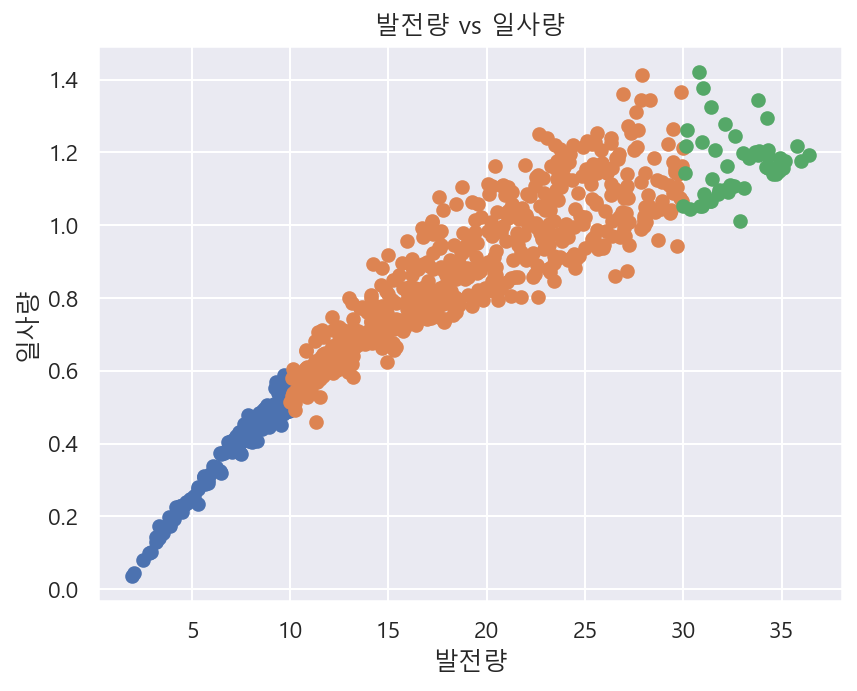

In [ ]:
# 태양광 발전량이 10미만인 날
x_0 = train_df.loc[train_df['TARGET']<10, 'TARGET']
y_0 = train_df.loc[train_df['TARGET']<10, '일사량']

# 태양광 발전량이 10이상 30미만인 날
x_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'TARGET']
y_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), '일사량']

# 태양광 발전량이 30이상인 날
x_2 = train_df.loc[train_df['TARGET']>=30, 'TARGET']
y_2 = train_df.loc[train_df['TARGET']>=30, '일사량']


# scatter 산점도 그래프 그리기
plt.figure(dpi=150) 

plt.title('발전량 vs 일사량')
plt.xlabel('발전량')
plt.ylabel('일사량')

plt.scatter(x_0, y_0)
plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

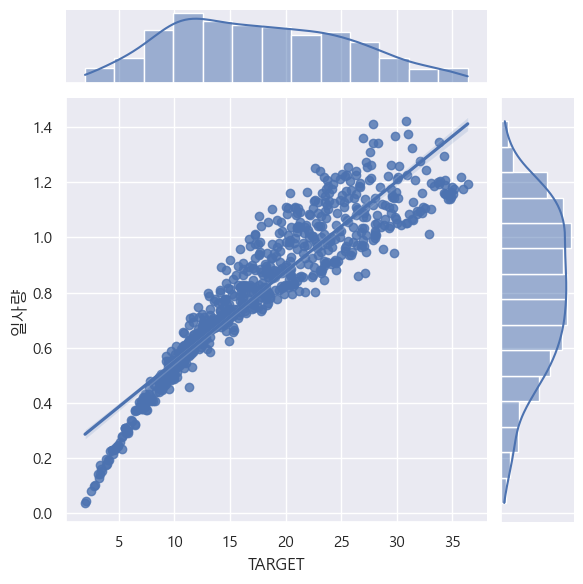

In [ ]:
g = sns.jointplot(train_df, x='TARGET', y='일사량',
                  kind='reg')
plt.show()

> 정리

막대그래프와 산점도 그래프를 통해 발전량과 일사량은 비례 관계임을 확인할 수 있다.

DHI와 DNI의 합에 평균값과 TARGET을 비교했을 때 각각의 변수에 대해 비교한 것보다 더 우상향의 산점도가 나타남을 확인할 수 있다.

따라서, 가설은 맞다.

### 3) 기온과 발전량

가설 > 기온이 높으면 태양광 발전량의 크기가 높을 것이다.(양의 상관관계)

In [ ]:
# T평균과 발전량 기준 10에 대해 표로 확인
TARGET_T = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 10, '> 10', '<= 10'))
          .groupby('발전량') 
          .agg(T_평균 = ('T', 'mean'))
          .reset_index()
          )

TARGET_T.head()

,발전량,T_평균
0,<= 10,-0.980903
1,> 10,0.222870


In [ ]:
TARGET_T = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 30, '> 30', '<= 30'))
          .groupby('발전량') 
          .agg(T_평균 = ('T', 'mean'))
          .reset_index()
          )

TARGET_T.head()

,발전량,T_평균
0,<= 30,-0.079323
1,> 30,1.130538


1 > 가설이 맞는지 발전량과 T 간의 막대그래프를 그려 확인한다.

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


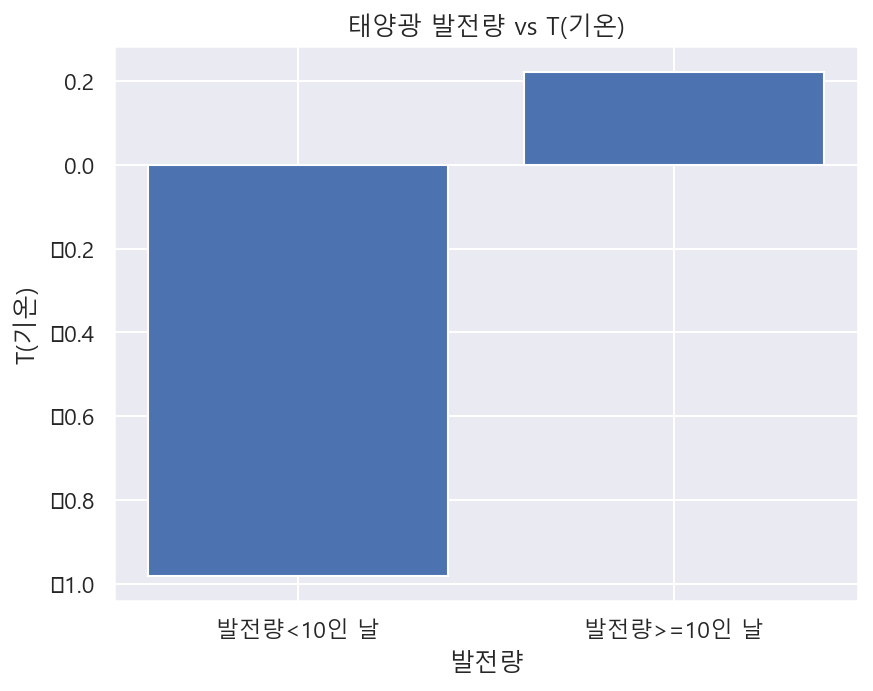

In [ ]:
# 태양광 발전량이 10미만인 날과 10이상인 날의 T 평균 비교
x = ['발전량<10인 날', '발전량>=10인 날']
y = [train_df[train_df['TARGET'] < 10]['T'].mean(), train_df[train_df['TARGET'] >= 10]['T'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs T(기온)")
plt.xlabel('발전량')
plt.ylabel('T(기온)')
plt.bar(x, y)
plt.show()

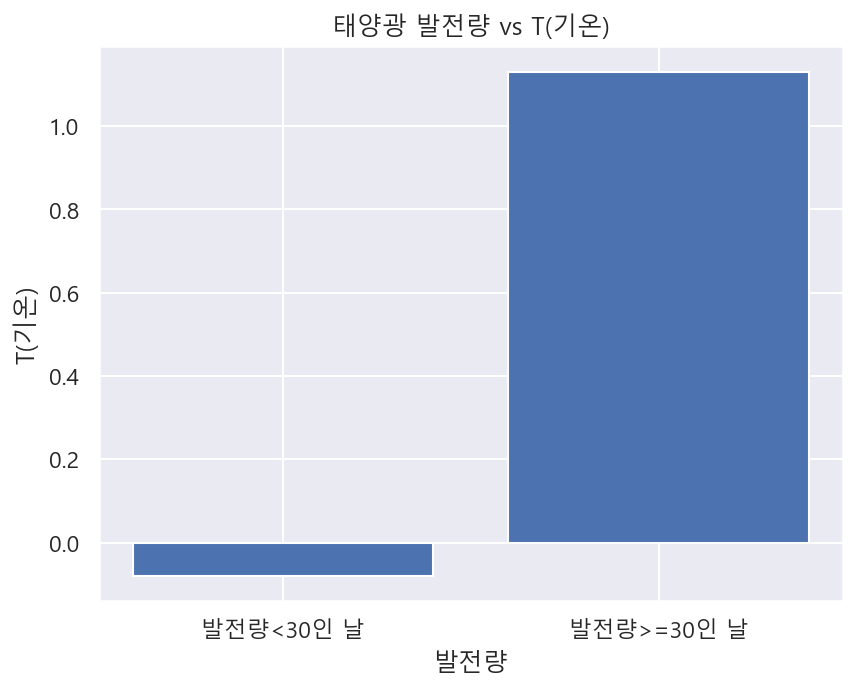

In [ ]:
# 태양광 발전량이 30미만인 날과 30이상인 날의 T 평균 비교
x = ['발전량<30인 날', '발전량>=30인 날']
y = [train_df[train_df['TARGET'] < 30]['T'].mean(), train_df[train_df['TARGET'] >= 30]['T'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs T(기온)")
plt.xlabel('발전량')
plt.ylabel('T(기온)')
plt.bar(x, y)
plt.show()

2 > 기온과 발전량 간의 상관관계를 확인한다.

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


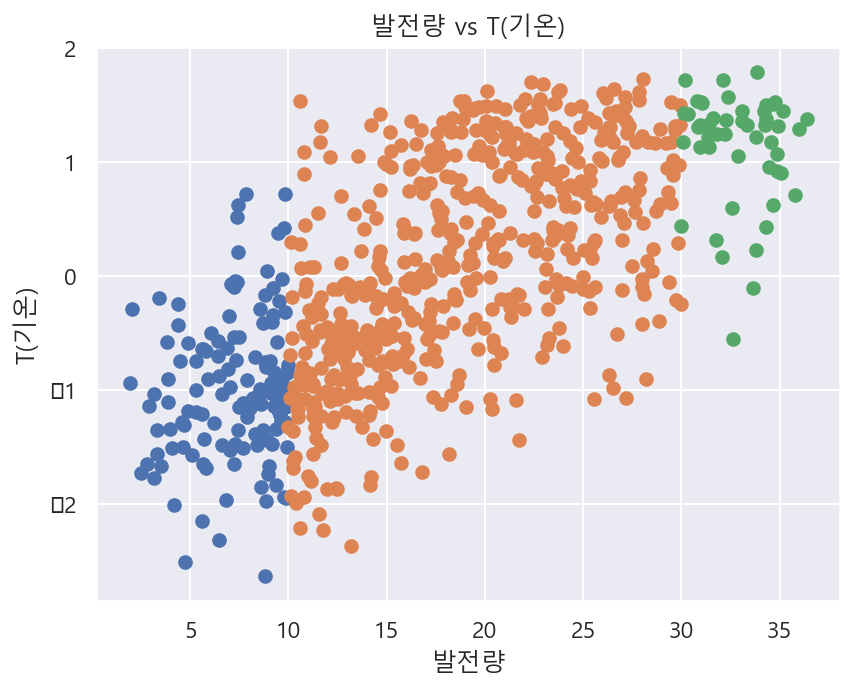

In [ ]:
# 태양광 발전량이 10미만인 날
x_0 = train_df.loc[train_df['TARGET']<10, 'TARGET']
y_0 = train_df.loc[train_df['TARGET']<10, 'T']

# 태양광 발전량이 10이상 30미만인 날
x_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'TARGET']
y_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'T']

# 태양광 발전량이 30이상인 날
x_2 = train_df.loc[train_df['TARGET']>=30, 'TARGET']
y_2 = train_df.loc[train_df['TARGET']>=30, 'T']


# scatter 산점도 그래프 그리기
plt.figure(dpi=150) 

plt.title('발전량 vs T(기온)')
plt.xlabel('발전량')
plt.ylabel('T(기온)')

plt.scatter(x_0, y_0)
plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


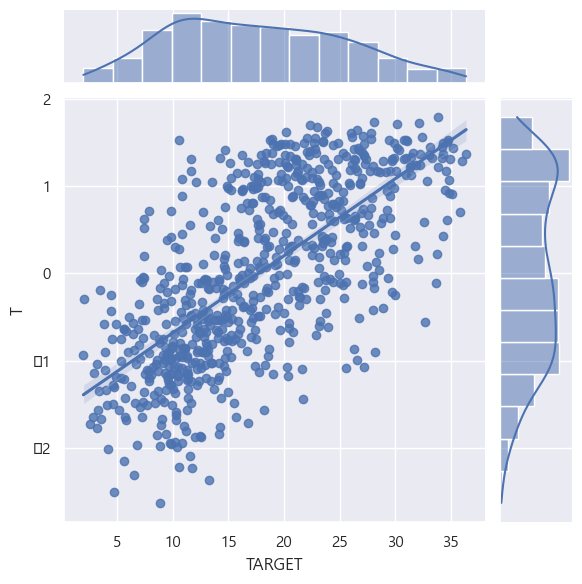

In [ ]:
g = sns.jointplot(train_df, x='TARGET', y='T',
                  kind='reg')
plt.show()

막대그래프와 산점도 그래프를 통해 발전량과 온도는 비례 관계임을 확인할 수 있다.

따라서, 가설은 맞다.

## EDA-2. feature 간의 EDA

### 4) 풍속, 상대습도와 발전량
가설 > 풍속은 발전량에 직접적인 영향을 미치기보다는 상대습도와 연관이 높을 것이다.

c:\Users\user\anaconda\envs\dacon\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:>

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


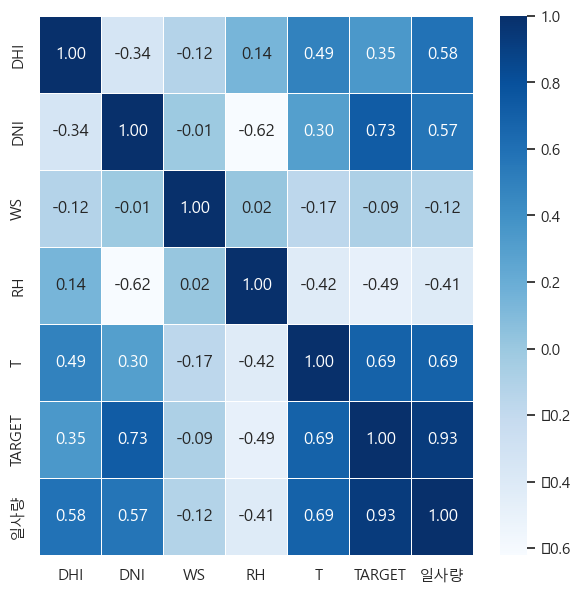

In [ ]:
# 전체 상관관계 확인

plt.figure(figsize=(7,7))
sns.heatmap(data = train_df.drop(['ID'], axis=1).corr(method='pearson'), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

- 각 상관관계 정리(절댓값)
1) DHI :  T > TARGET > DNI > RH > WS
2) DNI : TARGET > RH > DHI > T > WS
3) WS : T > DHI > TARGET > RH > DNI
4) RH : DNI > TARGET > T > DHI > WS
5) T : TARGET > DHI > RH > DNI > WS 
6) TARGET : DNI > T > RH > DHI > WS

1 > 가설이 맞는지 발전량과 풍속 간의 막대그래프를 그려 확인한다.

>> 풍속과 발전량

In [ ]:
# WS평균과 발전량 기준 10에 대해 표로 확인
TARGET_WS = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 10, '> 10', '<= 10'))
          .groupby('발전량') 
          .agg(WS_평균 = ('WS', 'mean'))
          .reset_index()
          )

TARGET_WS.head()

,발전량,WS_평균
0,<= 10,2.612516
1,> 10,2.422196


In [ ]:
# WS평균과 발전량 기준 30에 대해 표로 확인
TARGET_WS = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 30, '> 30', '<= 30'))
          .groupby('발전량') 
          .agg(WS_평균 = ('WS', 'mean'))
          .reset_index()
          )

TARGET_WS.head()

,발전량,WS_평균
0,<= 30,2.460177
1,> 30,2.409109


<BarContainer object of 2 artists>

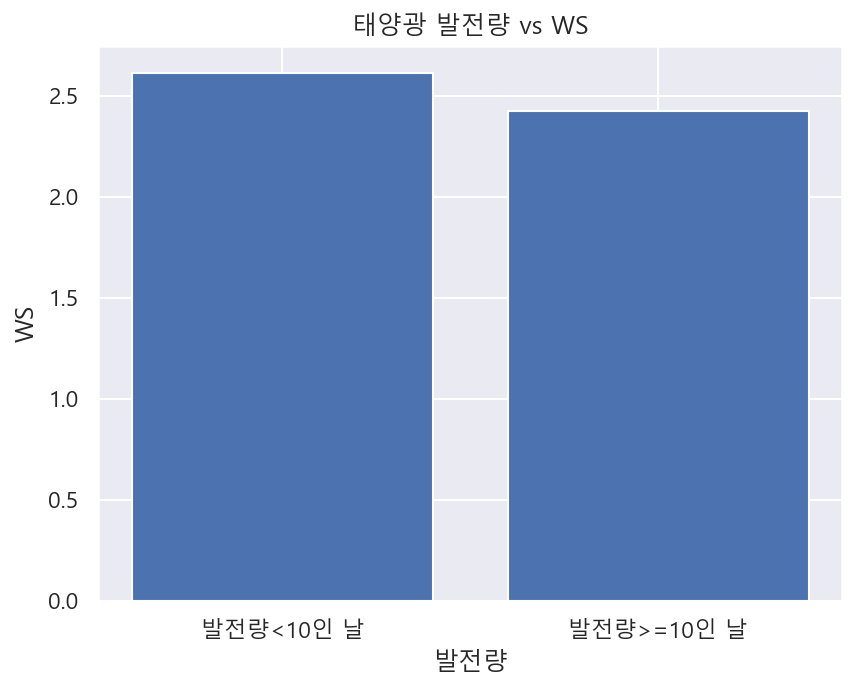

In [ ]:
#  태양광 발전량이 10미만인 날과 10이상인 날의 풍속 평균 비교
x = ['발전량<10인 날', '발전량>=10인 날']
y = [train_df[train_df['TARGET'] < 10]['WS'].mean(), train_df[train_df['TARGET'] >= 10]['WS'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs WS")
plt.xlabel('발전량')
plt.ylabel('WS')
plt.bar(x, y)

<BarContainer object of 2 artists>

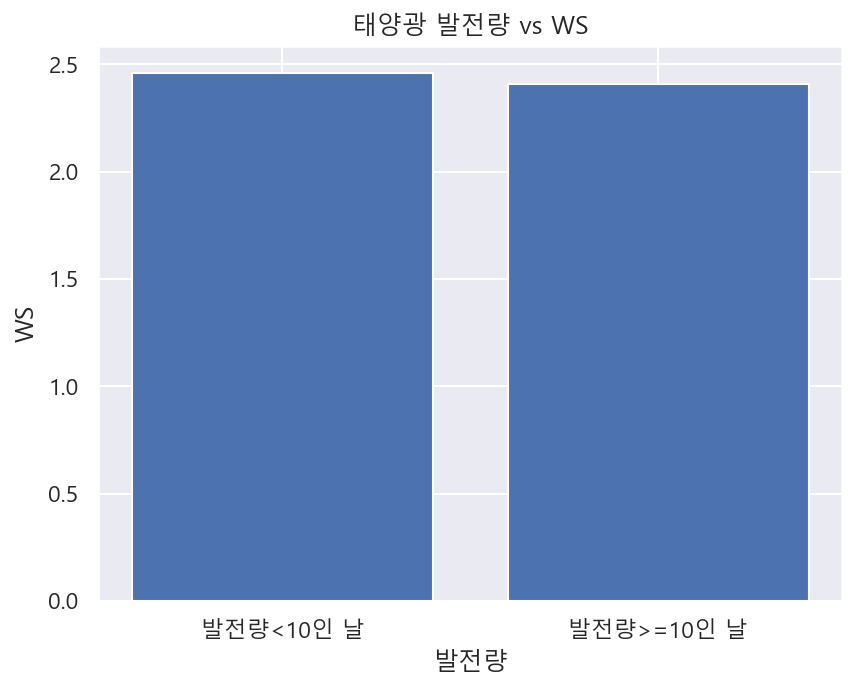

In [ ]:
#  태양광 발전량이 30미만인 날과 30이상인 날의 풍속 평균 비교
x = ['발전량<10인 날', '발전량>=10인 날']
y = [train_df[train_df['TARGET'] < 30]['WS'].mean(), train_df[train_df['TARGET'] >= 30]['WS'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs WS")
plt.xlabel('발전량')
plt.ylabel('WS')
plt.bar(x, y)

2 > 풍속과 발전량 간의 상관관계를 확인한다.

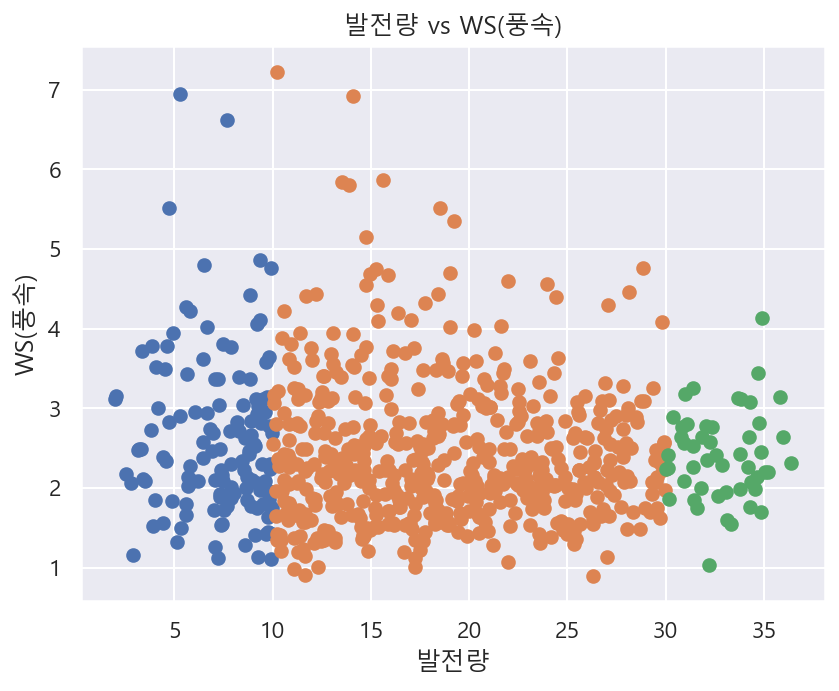

In [ ]:
# 태양광 발전량이 10미만인 날
x_0 = train_df.loc[train_df['TARGET']<10, 'TARGET']
y_0 = train_df.loc[train_df['TARGET']<10, 'WS']

# 태양광 발전량이 10이상 30미만인 날
x_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'TARGET']
y_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'WS']

# 태양광 발전량이 30이상인 날
x_2 = train_df.loc[train_df['TARGET']>=30, 'TARGET']
y_2 = train_df.loc[train_df['TARGET']>=30, 'WS']


# scatter 산점도 그래프 그리기
plt.figure(dpi=150) 

plt.title('발전량 vs WS(풍속)')
plt.xlabel('발전량')
plt.ylabel('WS(풍속)')

plt.scatter(x_0, y_0)
plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

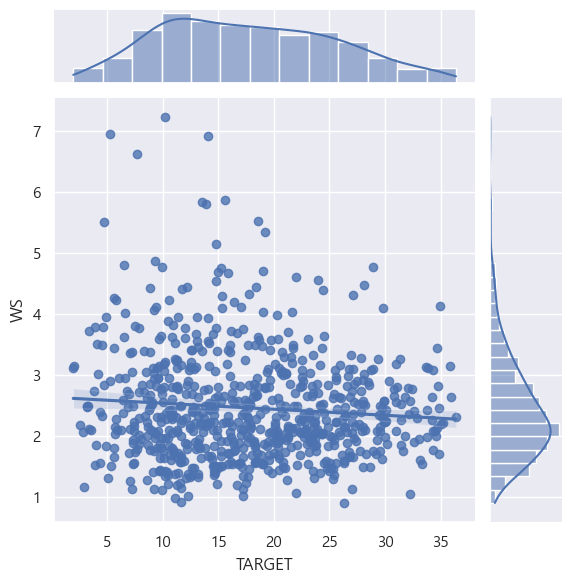

In [ ]:
g = sns.jointplot(train_df, x='TARGET', y='WS',
                  kind='reg')
plt.show()

> 정리

위의 막대그래프와 산점도를 통해 발전량과 풍속의 관계가 크지 않다는 것을 확인할 수 있다.

풍속과 상대습도의 관계를 살펴보자.



>> 풍속과 상대습도

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


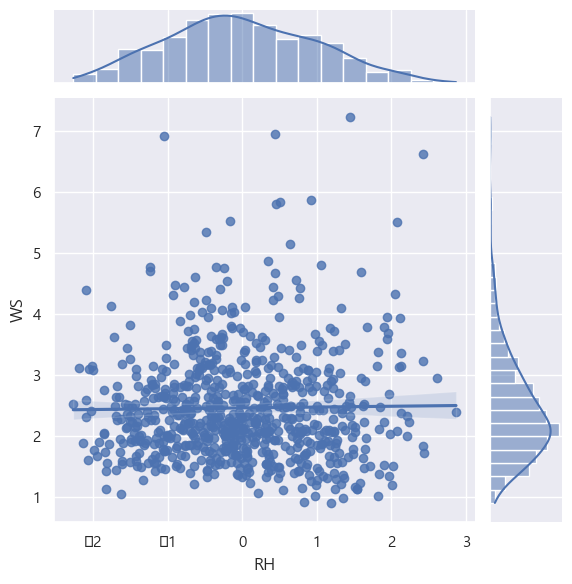

In [ ]:
g = sns.jointplot(train_df, x='RH', y='WS',
                  kind='reg')
plt.show()

> 정리

위의 산점도 그래프를 통해 그래프의 기울기가 수평에 가깝기 때문에 풍속과 상대습도의 관계가 크지 않다는 것을 확인할 수 있다.

전체 칼럼에 대한 상관관계 그래프에서 풍속은 기온과의 상관관계가 가장 높으므로 **풍속과 기온**의 관계를 살펴보자.


>> 풍속과 기온

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


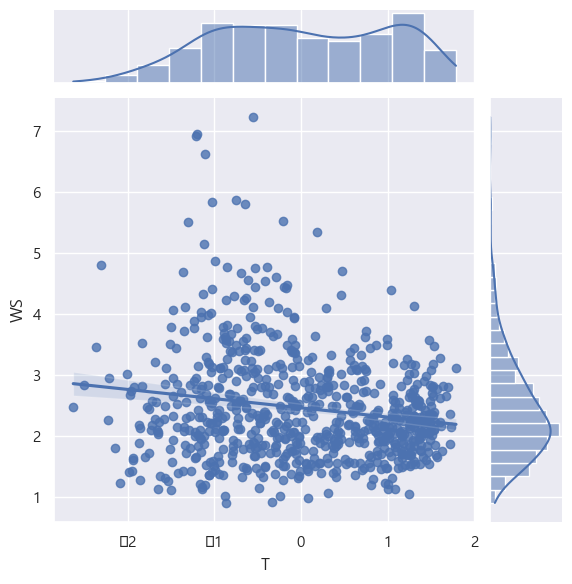

In [ ]:
g = sns.jointplot(train_df, x='T', y='WS',
                  kind='reg')
plt.show()

> 정리

위의 산점도 그래프를 통해 풍속과 기온의 관계가 음의 상관관계 라는 것을 확인할 수 있다.

따라서, 가설은 '풍속은 발전량에 직접적인 영향을 미치기보다는 기온과 연관이 높을 것이다.'라고 수정되어야한다. 

### 5) 풍속, 기온과 발전량

풍속과 기온의 관계를 확인했으니, 풍속과 기온을 합친 값에 대해 발전량과의 관계가 어떻게 되는지 확인해보자.

가설 > 풍속과 기온을 합한 값은 발전량에 영향이 있을 것이다.

In [ ]:
# 풍속과 기온 합에 대한 칼럼을 train에 할당
train_df = (train_df
    .assign(WS_T = lambda df: df['WS'] + df['T'])
)

train_df

,ID,DHI,DNI,WS,RH,T,TARGET,일사량,WS_T
0,1,0.315650,0.885087,3.129167,-0.563454,-0.106409,33.659014,1.200738,3.022758
1,2,0.075239,0.756084,3.068750,-1.030301,0.317479,20.747731,0.831323,3.386229
2,3,0.148714,0.628092,1.547917,-1.190128,0.411156,18.263065,0.776807,1.959072
3,4,0.821308,0.283800,3.020833,-0.218049,1.308111,21.072718,1.105108,4.328944
4,5,0.174578,0.592866,2.056250,0.286934,-0.312498,16.076963,0.767443,1.743752
...,...,...,...,...,...,...,...,...,...
725,726,0.501543,0.642224,2.918750,-1.219349,-0.094699,25.604709,1.143767,2.824051
726,727,0.082733,0.774102,3.110417,-0.612778,-0.563083,20.438856,0.856835,2.547334
727,728,0.587950,0.385512,2.704167,1.294474,0.839727,21.876819,0.973462,3.543894
728,729,0.816605,0.195044,1.656250,1.413581,0.811624,17.209349,1.011649,2.467874


In [ ]:
TARGET_WS_T = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 10, '> 10', '<= 10'))
          .groupby('발전량') 
          .agg(WS_T평균 = ('WS_T', 'mean'))
          .reset_index()
          )

TARGET_WS_T.head()

,발전량,WS_T평균
0,<= 10,1.631613
1,> 10,2.645065


In [ ]:
TARGET_WS_T = (train_df
          .assign(발전량 = lambda df: np.where(df['TARGET'] > 10, '> 30', '<= 30'))
          .groupby('발전량') 
          .agg(WS_T평균 = ('WS_T', 'mean'))
          .reset_index()
          )

TARGET_WS_T.head()

,발전량,WS_T평균
0,<= 30,1.631613
1,> 30,2.645065


1 > 가설이 맞는지 발전량과 WS_T 간의 막대그래프를 그려 확인한다.

<BarContainer object of 2 artists>

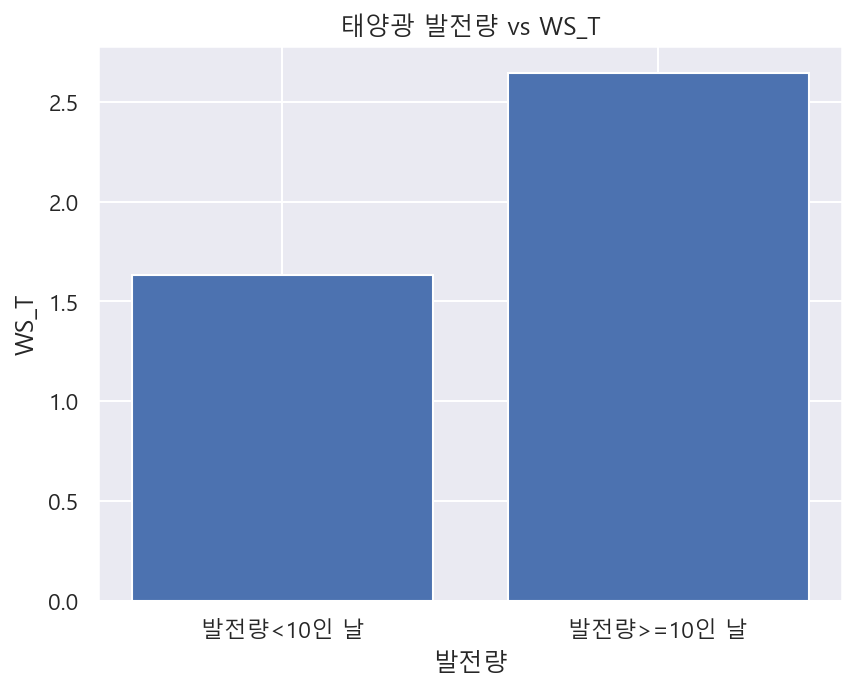

In [ ]:
#  태양광 발전량이 10미만인 날과 10이상인 날의 풍속+기온 평균 비교
x = ['발전량<10인 날', '발전량>=10인 날']
y = [train_df[train_df['TARGET'] < 10]['WS_T'].mean(), train_df[train_df['TARGET'] >= 10]['WS_T'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs WS_T")
plt.xlabel('발전량')
plt.ylabel('WS_T')
plt.bar(x, y)

<BarContainer object of 2 artists>

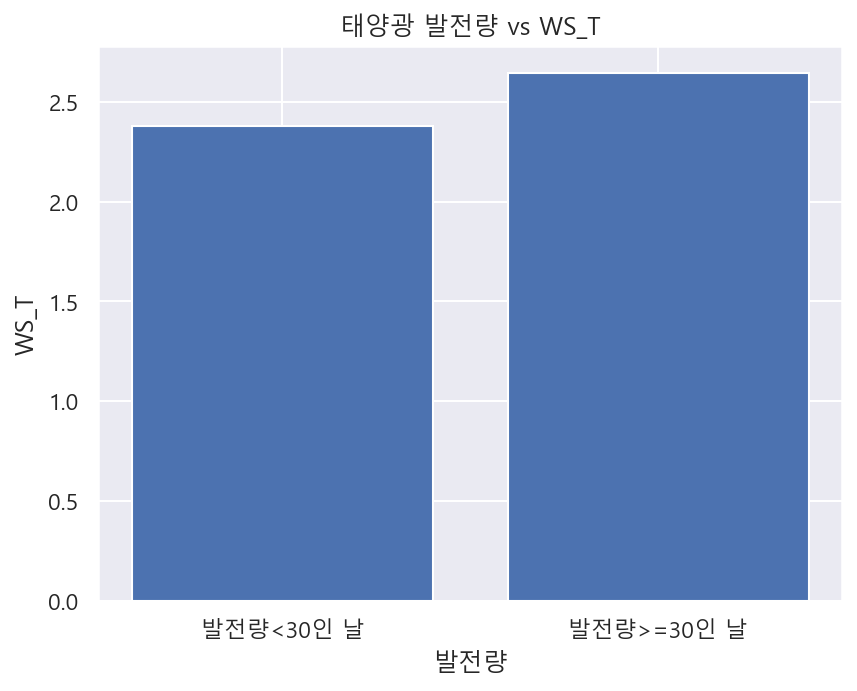

In [ ]:
#  태양광 발전량이 30미만인 날과 30이상인 날의 풍속+기온 평균 비교
x = ['발전량<30인 날', '발전량>=30인 날']
y = [train_df[train_df['TARGET'] < 30]['WS_T'].mean(), train_df[train_df['TARGET'] >= 10]['WS_T'].mean()]

plt.figure(dpi=150)
plt.title("태양광 발전량 vs WS_T")
plt.xlabel('발전량')
plt.ylabel('WS_T')
plt.bar(x, y)

2 > WS_T와 발전량 간의 상관관계를 확인한다.

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


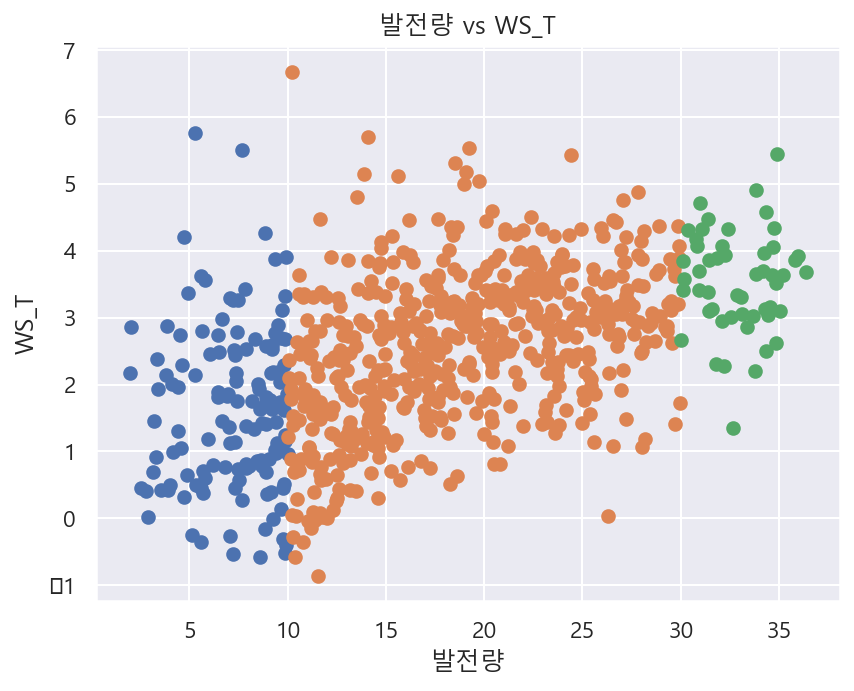

In [ ]:
# 태양광 발전량이 10미만인 날
x_0 = train_df.loc[train_df['TARGET']<10, 'TARGET']
y_0 = train_df.loc[train_df['TARGET']<10, 'WS_T']

# 태양광 발전량이 10이상 30미만인 날
x_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'TARGET']
y_1 = train_df.loc[(train_df['TARGET']>=10)&(train_df['TARGET']<30), 'WS_T']

# 태양광 발전량이 30이상인 날
x_2 = train_df.loc[train_df['TARGET']>=30, 'TARGET']
y_2 = train_df.loc[train_df['TARGET']>=30, 'WS_T']


# scatter 산점도 그래프 그리기
plt.figure(dpi=150) 

plt.title('발전량 vs WS_T')
plt.xlabel('발전량')
plt.ylabel('WS_T')

plt.scatter(x_0, y_0)
plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


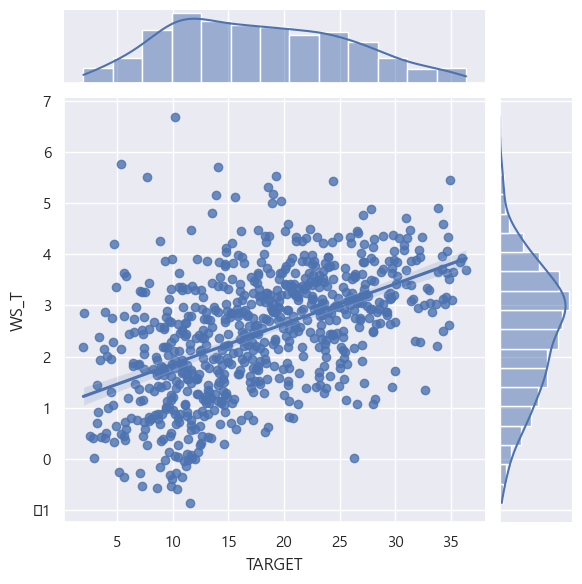

In [ ]:
g = sns.jointplot(train_df, x='TARGET', y='WS_T',
                  kind='reg')
plt.show()

>> 정리

상대습도, 기온과 풍속의 관계성을 살펴본 뒤 기온+풍속, 발전량의 관계를 살펴보았다.

위의 BOXPLOT과 산점도를 통해 기온+풍속, 발전량은 양의 상관관계를 가진다는 것을 확인할 수 있다.

### 6) 전체 feature

- feature의 상관관계 확인

In [ ]:
train_df

,ID,DHI,DNI,WS,RH,T,TARGET,일사량,WS_T
0,1,0.315650,0.885087,3.129167,-0.563454,-0.106409,33.659014,1.200738,3.022758
1,2,0.075239,0.756084,3.068750,-1.030301,0.317479,20.747731,0.831323,3.386229
2,3,0.148714,0.628092,1.547917,-1.190128,0.411156,18.263065,0.776807,1.959072
3,4,0.821308,0.283800,3.020833,-0.218049,1.308111,21.072718,1.105108,4.328944
4,5,0.174578,0.592866,2.056250,0.286934,-0.312498,16.076963,0.767443,1.743752
...,...,...,...,...,...,...,...,...,...
725,726,0.501543,0.642224,2.918750,-1.219349,-0.094699,25.604709,1.143767,2.824051
726,727,0.082733,0.774102,3.110417,-0.612778,-0.563083,20.438856,0.856835,2.547334
727,728,0.587950,0.385512,2.704167,1.294474,0.839727,21.876819,0.973462,3.543894
728,729,0.816605,0.195044,1.656250,1.413581,0.811624,17.209349,1.011649,2.467874


In [ ]:
feature_df = (train_df
 .loc[:, ['DHI','DNI','WS','RH','T','TARGET', '일사량', 'WS_T']]
 .melt(id_vars='TARGET',
       var_name='분류', value_name='수치')
 )

feature_df

,TARGET,분류,수치
0,33.659014,DHI,0.315650
1,20.747731,DHI,0.075239
2,18.263065,DHI,0.148714
3,21.072718,DHI,0.821308
4,16.076963,DHI,0.174578
...,...,...,...
5105,25.604709,WS_T,2.824051
5106,20.438856,WS_T,2.547334
5107,21.876819,WS_T,3.543894
5108,17.209349,WS_T,2.467874


c:\Users\user\anaconda\envs\dacon\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


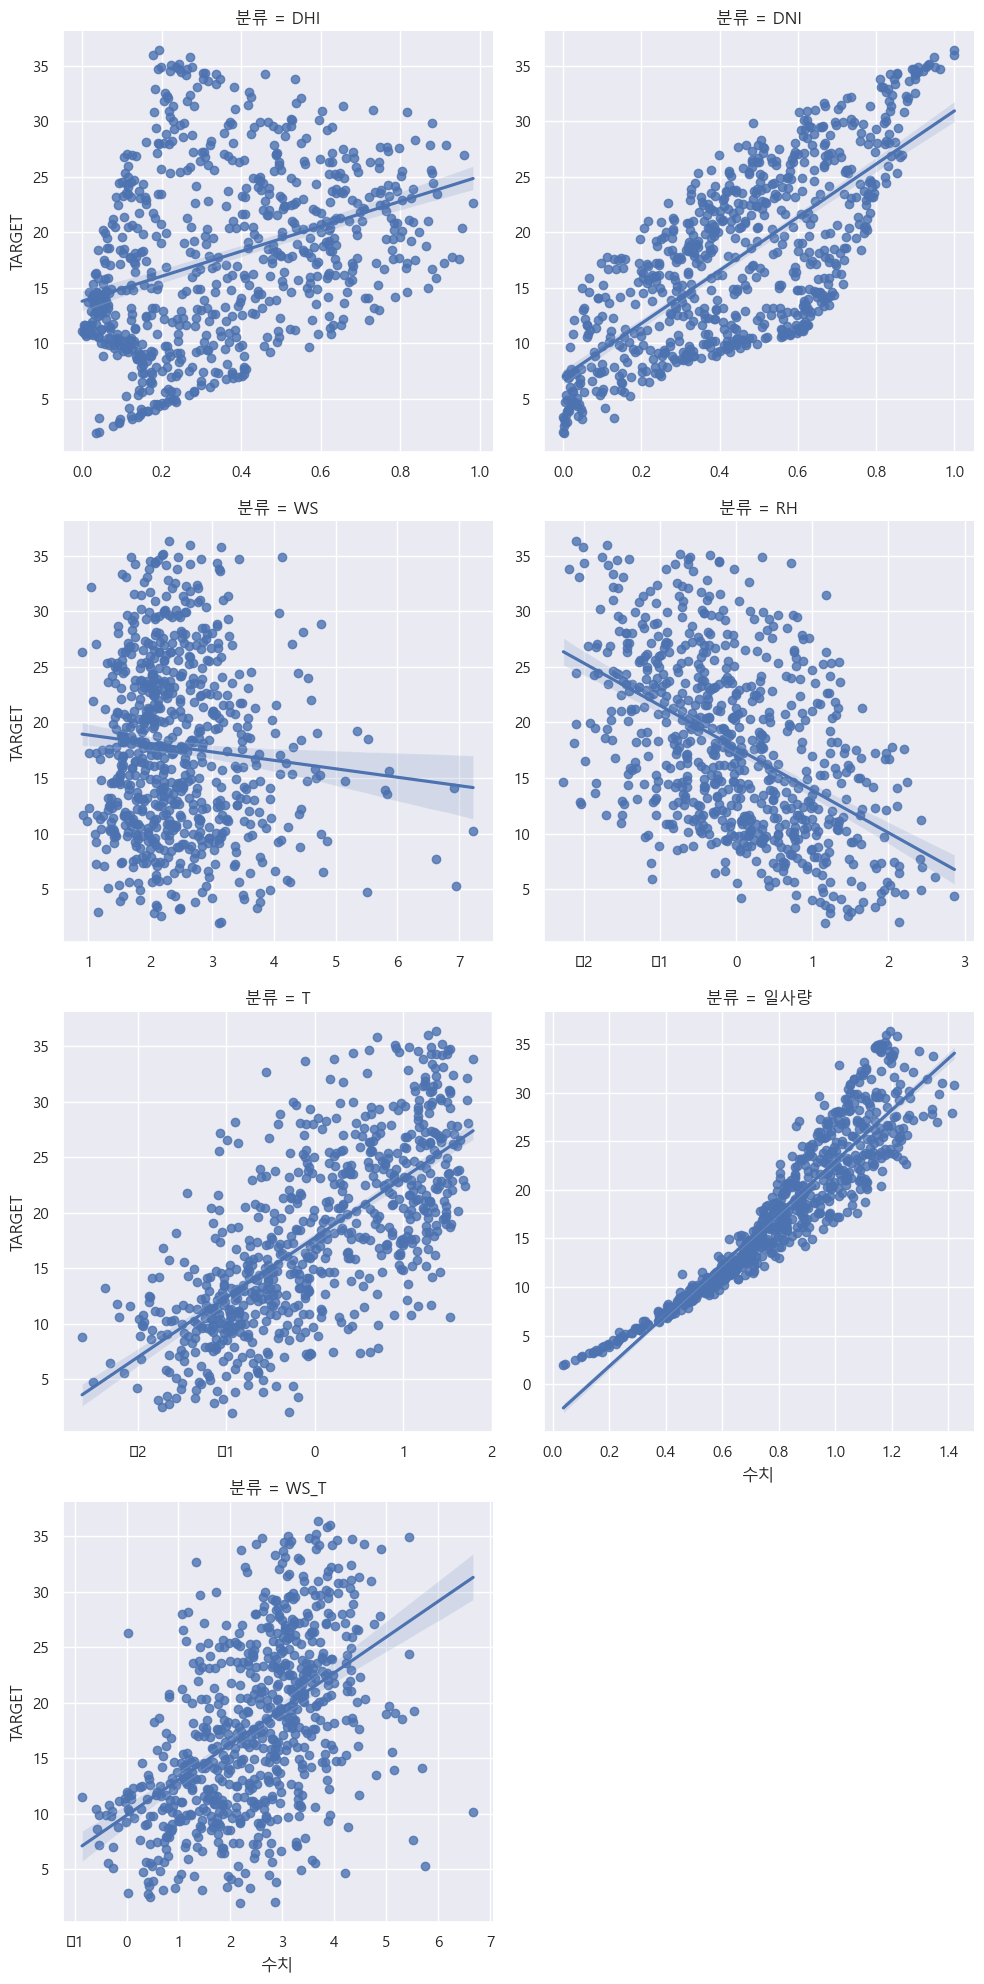

In [ ]:
# TARGET과 feature 전체에 대한 상관관계 확인
sns.lmplot(feature_df, x='수치',  y='TARGET', col='분류', col_wrap=2,
           facet_kws={'sharex': False, 'sharey': False})
plt.show()


c:\Users\user\anaconda\envs\dacon\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:>

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


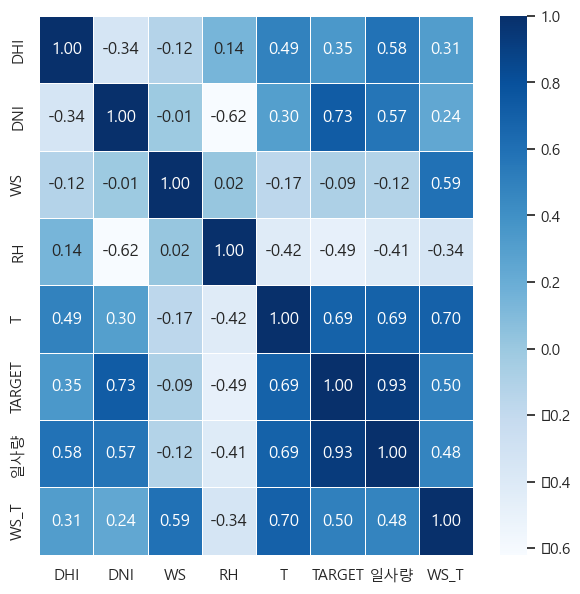

In [ ]:
# 전체 상관관계 확인

plt.figure(figsize=(7,7))
sns.heatmap(data = train_df.drop(['ID'], axis=1).corr(method='pearson'), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

- 이상치 확인

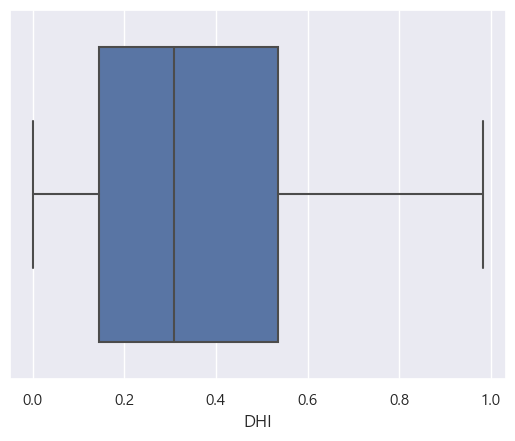

In [ ]:
g = sns.boxplot(train_df, x='DHI')
g.set_xlabel('DHI')

plt.show()

# 이상치 없음

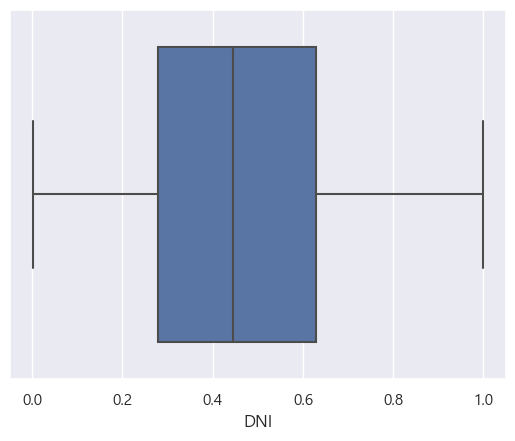

In [ ]:
g = sns.boxplot(train_df, x='DNI')
g.set_xlabel('DNI')

plt.show()

# 이상치 없음

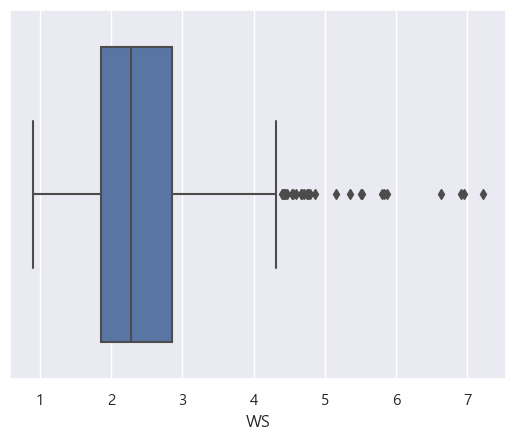

In [ ]:
g = sns.boxplot(train_df, x='WS')
g.set_xlabel('WS')

plt.show()

# 이상치 있음 > 예측할 때 제거해야할 대상임

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


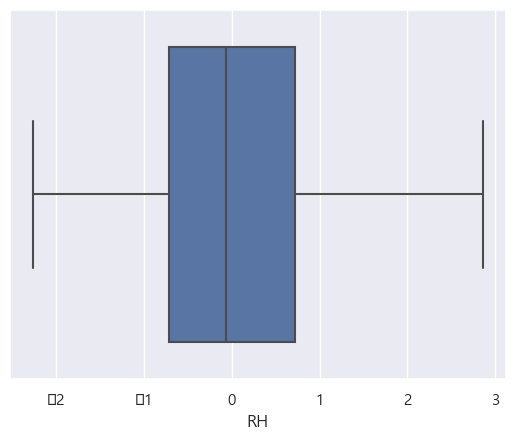

In [ ]:
g = sns.boxplot(train_df, x='RH')
g.set_xlabel('RH')

plt.show()

# 이상치 없음

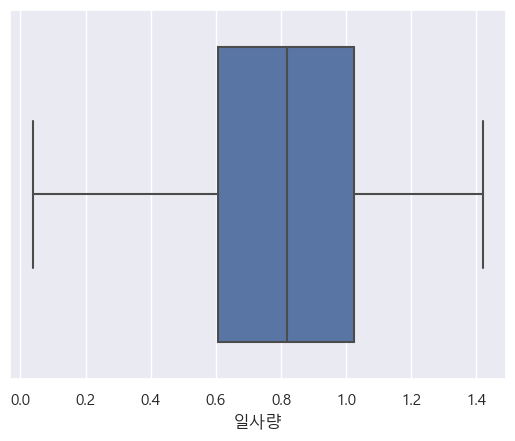

In [ ]:
g = sns.boxplot(train_df, x='일사량')
g.set_xlabel('일사량')

plt.show()

# 이상치 없음

c:\Users\user\anaconda\envs\dacon\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


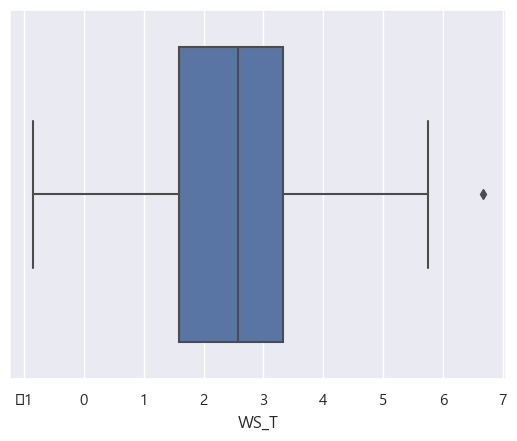

In [ ]:
g = sns.boxplot(train_df, x='WS_T')
g.set_xlabel('WS_T')

plt.show()

# 이상치 있음 > 예측할 때 제거해야할 대상임

-------------------------------------------------------------------------------------------------------

# 3. 모델링

### 랜덤포레스트

- 대표적인 앙상블(ensemble) 모델의 일종

- "여러 개의 트리 모델" 에 "서로 다른 데이터"를 투입하여 나온 결과를 종합하여 가장 많은 투표(Voting)를 얻은 결과를 최종 결과로 선택하는 방식으로 작동

- **과적합(Overfitting)을 방지** 기능

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

In [ ]:
train_df = train_df.drop(columns=['ID'])
test_df = test_df.drop(columns=['ID'])

In [ ]:
train_df

,DHI,DNI,WS,RH,T,TARGET,일사량,WS_T
0,0.315650,0.885087,3.129167,-0.563454,-0.106409,33.659014,1.200738,3.022758
1,0.075239,0.756084,3.068750,-1.030301,0.317479,20.747731,0.831323,3.386229
2,0.148714,0.628092,1.547917,-1.190128,0.411156,18.263065,0.776807,1.959072
3,0.821308,0.283800,3.020833,-0.218049,1.308111,21.072718,1.105108,4.328944
4,0.174578,0.592866,2.056250,0.286934,-0.312498,16.076963,0.767443,1.743752
...,...,...,...,...,...,...,...,...
725,0.501543,0.642224,2.918750,-1.219349,-0.094699,25.604709,1.143767,2.824051
726,0.082733,0.774102,3.110417,-0.612778,-0.563083,20.438856,0.856835,2.547334
727,0.587950,0.385512,2.704167,1.294474,0.839727,21.876819,0.973462,3.543894
728,0.816605,0.195044,1.656250,1.413581,0.811624,17.209349,1.011649,2.467874


In [ ]:
X = train_df.drop(columns=['TARGET'])
y_train = train_df['TARGET']

In [ ]:
model.fit(X,y_train)

RandomForestRegressor()

In [ ]:
test_df = (test_df
    .assign(일사량 = lambda df: df['DHI'] + df['DNI'])
)

test_df

,DHI,DNI,WS,RH,T,일사량
0,0.300661,0.500871,4.272917,0.005448,-0.556057,0.801532
1,0.595151,0.761307,4.385417,-1.171177,0.909985,1.356458
2,0.069508,0.535166,1.795833,0.866136,-0.970577,0.604674
3,0.758707,0.406851,3.597917,0.263797,-0.171982,1.165558
4,0.098751,0.772563,2.279167,-0.915363,-0.783224,0.871314
...,...,...,...,...,...,...
360,0.081117,0.524193,2.237500,0.235292,-0.111093,0.605310
361,0.024541,0.657084,1.985417,-0.219885,-2.469406,0.681625
362,0.111242,0.391788,1.212500,1.482526,-1.366362,0.503030
363,0.316091,0.266753,2.681250,0.206974,-0.518587,0.582844


In [ ]:
test_df = (test_df
    .assign(WS_T = lambda df: df['WS'] + df['T'])
)
test_df

,DHI,DNI,WS,RH,T,일사량,WS_T
0,0.300661,0.500871,4.272917,0.005448,-0.556057,0.801532,3.716859
1,0.595151,0.761307,4.385417,-1.171177,0.909985,1.356458,5.295401
2,0.069508,0.535166,1.795833,0.866136,-0.970577,0.604674,0.825256
3,0.758707,0.406851,3.597917,0.263797,-0.171982,1.165558,3.425934
4,0.098751,0.772563,2.279167,-0.915363,-0.783224,0.871314,1.495943
...,...,...,...,...,...,...,...
360,0.081117,0.524193,2.237500,0.235292,-0.111093,0.605310,2.126407
361,0.024541,0.657084,1.985417,-0.219885,-2.469406,0.681625,-0.483990
362,0.111242,0.391788,1.212500,1.482526,-1.366362,0.503030,-0.153862
363,0.316091,0.266753,2.681250,0.206974,-0.518587,0.582844,2.162663


In [ ]:
prediction = model.predict(test_df)

In [ ]:
sample_submission = pd.read_csv('data/data/sample_submission.csv')
sample_submission['TARGET'] = prediction
sample_submission.head(3)

# 모든 칼럼에 대해 예측한 파일
sample_submission.to_csv('submission_1028(2).csv',index = False)

------------------------------------------------------------------------------------

## 4. 변수 중요도와 모델링

학습이 완료된 모델에 변수 중요도를 확인하여 모델을 예측할 때 중요하게 작용하는 변수가 무엇인지 확인한다.

> 1차 변수 중요도 확인

전체 칼럼에 대해서 변수 중요도를 확인한다.

In [ ]:
train_df.columns

Index(['DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', '일사량', 'WS_T'], dtype='object')

In [ ]:
features_1 = ['ID', 'DHI', 'DNI', 'WS', 'RH', 'T','일사량', 'WS_T']

features_1

['ID', 'DHI', 'DNI', 'WS', 'RH', 'T', '일사량', 'WS_T']

In [ ]:
# ID 칼럼은 예측에 필요없기 때문에 제거
features_1.remove('ID')
features_1

['DHI', 'DNI', 'WS', 'RH', 'T', '일사량', 'WS_T']

In [ ]:
# 변수 중요도 수치로 확인
model.feature_importances_

array([0.00349326, 0.12166016, 0.00200561, 0.00283525, 0.00513955,
       0.86241746, 0.00244871])

In [ ]:
# 변수 중요도 총합 확인
model.feature_importances_.sum()

1.0

<AxesSubplot:>

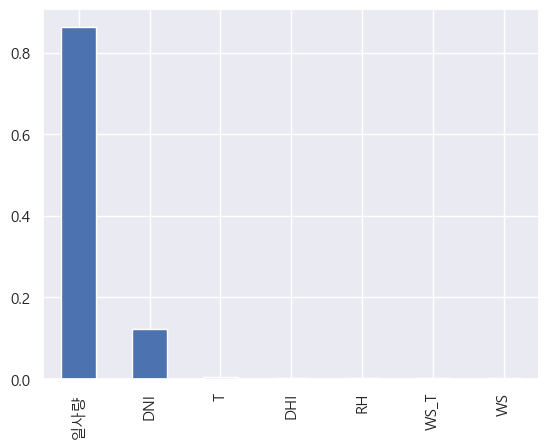

In [ ]:
# 변수 중요도 시각화
fcheck = pd.Series(model.feature_importances_,
                    index=features_1)\
        .sort_values(ascending=False)
        
fcheck.plot.bar()

변수 중요도를 통해 WS, WS_T가 0.00189903, 0.00225473으로 낮은 것을 확인할 수 있다. 

> 1차 모델링

전체 칼럼의 변수중요도를 통해 어떤 변수가 예측할 때 필요없는지 확인할 수 있었다.

가장 중요도가 낮은 WS, WS_T를 삭제하고 모델링한다.

In [ ]:
train_df

,DHI,DNI,WS,RH,T,TARGET,일사량,WS_T
0,0.315650,0.885087,3.129167,-0.563454,-0.106409,33.659014,1.200738,3.022758
1,0.075239,0.756084,3.068750,-1.030301,0.317479,20.747731,0.831323,3.386229
2,0.148714,0.628092,1.547917,-1.190128,0.411156,18.263065,0.776807,1.959072
3,0.821308,0.283800,3.020833,-0.218049,1.308111,21.072718,1.105108,4.328944
4,0.174578,0.592866,2.056250,0.286934,-0.312498,16.076963,0.767443,1.743752
...,...,...,...,...,...,...,...,...
725,0.501543,0.642224,2.918750,-1.219349,-0.094699,25.604709,1.143767,2.824051
726,0.082733,0.774102,3.110417,-0.612778,-0.563083,20.438856,0.856835,2.547334
727,0.587950,0.385512,2.704167,1.294474,0.839727,21.876819,0.973462,3.543894
728,0.816605,0.195044,1.656250,1.413581,0.811624,17.209349,1.011649,2.467874


In [ ]:
test_df

,DHI,DNI,WS,RH,T,일사량,WS_T
0,0.300661,0.500871,4.272917,0.005448,-0.556057,0.801532,3.716859
1,0.595151,0.761307,4.385417,-1.171177,0.909985,1.356458,5.295401
2,0.069508,0.535166,1.795833,0.866136,-0.970577,0.604674,0.825256
3,0.758707,0.406851,3.597917,0.263797,-0.171982,1.165558,3.425934
4,0.098751,0.772563,2.279167,-0.915363,-0.783224,0.871314,1.495943
...,...,...,...,...,...,...,...
360,0.081117,0.524193,2.237500,0.235292,-0.111093,0.605310,2.126407
361,0.024541,0.657084,1.985417,-0.219885,-2.469406,0.681625,-0.483990
362,0.111242,0.391788,1.212500,1.482526,-1.366362,0.503030,-0.153862
363,0.316091,0.266753,2.681250,0.206974,-0.518587,0.582844,2.162663


In [ ]:
train_df = train_df.drop(columns=['WS','WS_T'])
test_df = test_df.drop(columns=['WS','WS_T'])

In [ ]:
model = RandomForestRegressor()

In [ ]:
X = train_df.drop(columns=['TARGET'])
y_train = train_df['TARGET']

In [ ]:
model.fit(X,y_train)

prediction = model.predict(test_df)

sample_submission = pd.read_csv('data/data/sample_submission.csv')
sample_submission['TARGET'] = prediction
sample_submission.head(3)

,ID,TARGET
0,1,17.114292
1,2,30.665749
2,3,11.483658


In [ ]:
# WS_T, WS 칼럼 제거
sample_submission.to_csv('submission_1028(3).csv',index = False)

> 2차 변수중요도 확인

변수중요도를 다시 실시하여 추가적으로 삭제할 칼럼이 없는지 확인한다.

In [ ]:
features_2 = ['DHI', 'DNI', 'RH', 'T','일사량']

features_2

['DHI', 'DNI', 'RH', 'T', '일사량']

In [ ]:
# 변수 중요도 수치로 확인
model.feature_importances_

array([0.00406693, 0.12438181, 0.00362423, 0.00688034, 0.86104668])

<AxesSubplot:>

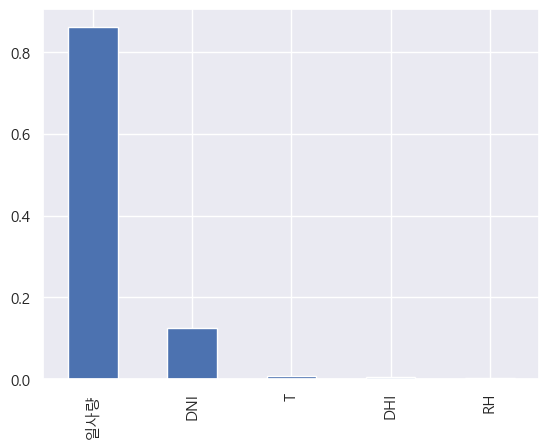

In [ ]:
# 변수 중요도 시각화
fcheck = pd.Series(model.feature_importances_,
                    index=features_2)\
        .sort_values(ascending=False)
        
fcheck.plot.bar()

변수 중요도를 통해 RH가 0.00373473으로 낮은 것을 확인할 수 있다.

> 2차 모델링

WS_T와 WS 제거된 칼럼의 변수중요도를 통해 어떤 변수가 예측할 때 필요없는지 확인할 수 있었다.

 가장 중요도가 낮은 RH를 삭제하고 모델링한다.

In [ ]:
train_df = train_df.drop(columns=['RH'])
test_df = test_df.drop(columns=['RH'])

In [ ]:
model = RandomForestRegressor()

In [ ]:
X = train_df.drop(columns=['TARGET'])
y_train = train_df['TARGET']

In [ ]:
model.fit(X,y_train)

prediction = model.predict(test_df)

sample_submission = pd.read_csv('data/data/sample_submission.csv')
sample_submission['TARGET'] = prediction
sample_submission.head(3)

,ID,TARGET
0,1,17.151297
1,2,30.893585
2,3,11.427323


In [ ]:
# RH 칼럼 제거
sample_submission.to_csv('submission_1028(4).csv',index = False)

# 5. 하이퍼 파라미터

### 1) 랜덤포레스트의 하이퍼 파라미터

> RandomForestRegressor의 하이퍼 파라미터

- **n_estimators** : 결정트리의 개수(defalut=10)
- **criterion** : 분할된 것(split)의 품질을 측정하는 기능
- max_depth : 트리의 최대 깊이
- min_samples_split : 노드를 분할하기 위한 최소한의 샘플 데이터수

In [ ]:
# 랜덤포레스트의 하이퍼 파라미터 확인
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

> 랜덤포레스트의 하이퍼 파라미터의 값을 지정해준 후 모델링

In [ ]:
model = RandomForestRegressor(n_estimators=200, criterion='absolute_error', max_depth = 25,
                              max_features =1.0, min_samples_leaf = 1, min_samples_split = 2)

>> 임의로 지정

- n_estimators

n_estimators을 기준 200으로 했을 때, 이상치 확인 이전에는 100이 가장 정확도가 높았으나 이상치 확인 이후에는 200이 가장 정확도가 높게 나왔다. 

또한, 200보다 큰 값을 넣어주었을 때에는 정확도가 떨어지는 것을 확인했기 때문에 200으로 default 하겠다.

- criterian

absolute_error와 squared_error를 비교했을 때, absolute_error의 정확도가 높게 나오는 것을 확인했기 때문에 absolute_error로 default로 하겠다.

- max_depth

max_depth을 기준 25로 했을 때, 25보다 작은 값에서 정확도가 낮게 나오기 때문에 25로 default 하겠다.


In [ ]:
X = train_df.drop(columns=['TARGET'])
y_train = train_df['TARGET']

In [ ]:
model.fit(X,y_train)

prediction = model.predict(test_df)

sample_submission = pd.read_csv('data/data/sample_submission.csv')
sample_submission['TARGET'] = prediction
sample_submission.head(3)

,ID,TARGET
0,1,17.237008
1,2,31.248425
2,3,11.326293


In [ ]:
# WS_T, WS, RH 칼럼 제거, 하이퍼 파라미터 튜닝 전
sample_submission.to_csv('submission_1029(1).csv',index = False)

### 2) 랜덤포레스트 하이퍼 파라미터 튜닝

[출처] https://dacon.io/codeshare/4568?page&dtype&ptype&fType

1> GridSearchCV

- 실험하고자 하는 하이퍼파라미터의 값 범위를 지정하면, 교차 검증을 통해 하이퍼 파라미터 값의 가능한 모든 조합을 수행하는 모듈이다.

- 하이퍼 파리미터에 대해 "딕셔너리" 형태로 파라미터 셋을 입력한다.

- 파라미터가 많을수록 검증해야하는 조합이 늘어나기 때문에 실행 시간이 오래걸란다.

- 인자
: estimators, param_grid, scoring, cv, refit




In [ ]:
train_df

,DHI,DNI,T,TARGET,일사량
0,0.315650,0.885087,-0.106409,33.659014,1.200738
1,0.075239,0.756084,0.317479,20.747731,0.831323
2,0.148714,0.628092,0.411156,18.263065,0.776807
3,0.821308,0.283800,1.308111,21.072718,1.105108
4,0.174578,0.592866,-0.312498,16.076963,0.767443
...,...,...,...,...,...
725,0.501543,0.642224,-0.094699,25.604709,1.143767
726,0.082733,0.774102,-0.563083,20.438856,0.856835
727,0.587950,0.385512,0.839727,21.876819,0.973462
728,0.816605,0.195044,0.811624,17.209349,1.011649


In [ ]:
X = train_df.drop(columns=['TARGET'])
y_train = train_df['TARGET']

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=0, n_jobs=-1)
parameters = {'n_estimators' : [200], 'max_depth':[5,10,15,20], 'max_samples' : [0.2, 0.4, 0.7, 0.8, 0.9, 1.0], 'max_features':[0.2, 0.4, 0.7, 0.8, 0.9, 1.0]}
model_Grid= GridSearchCV(model, param_grid=parameters, cv=3, n_jobs=-1)

model_Grid.fit(X, y_train)

print('best parameters : ', model_Grid.best_params_)
print('best score : ', round(model_Grid.best_score_, 4))

best parameters :  {'max_depth': 10, 'max_features': 0.7, 'max_samples': 0.8, 'n_estimators': 200}
best score :  0.9792


In [ ]:
model = RandomForestRegressor(n_estimators=200, criterion ='absolute_error', max_depth = 10, 
                              max_features = 0.7, max_samples= 0.8)

In [ ]:
model.fit(X, y_train)

prediction_Grid = model.predict(test_df)

sample_submission = pd.read_csv('data/data/sample_submission.csv')
sample_submission['TARGET'] = prediction_Grid
sample_submission.head(3)

,ID,TARGET
0,1,17.397891
1,2,30.736091
2,3,11.387396


In [ ]:
# WS_T, WS, RH 칼럼 제거, 하이퍼 파라미터 튜닝 후
sample_submission.to_csv('submission_1029(2).csv',index = False) 

2> RandomizedSearchCV

- 파라미터 값의 가능한 모든 조합을 수행하나, 각 반복마다 임의의 값만 대입해 지정한 횟수만큼 평가하는 모듈이다.

- 실행 시간이 적게 걸린다.

- 인자
: estimators, param_grid, scoring, cv, refit, param_distributions, n_iter

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.tree import DecisionTreeRegressor

# model = DecisionTreeRegressor()

# param_dist = {
#     'max_depth':[None, 2,3,4,5,6], 
#     'max_leaf_nodes':[None, 2,3,4,5,6,7], 
#     'min_samples_split':[None, 2,3,4,5,6], 
#     'min_samples_leaf':[None, 1,2,3], 
#     'max_features':[None,'sqrt','log2',3,4,5]
#     }

In [ ]:
# model_RDS = RandomizedSearchCV(model, param_distributions = param_dist, n_iter = 50, cv = 5, scoring = 'accuracy', refit=True)
# model_RDS.fit(X, y_train)

In [ ]:
# print('best parameters : ', model_RDS.best_params_)
# print('best score : ', round(model_RDS.best_score_, 4))

In [ ]:
# model = DecisionTreeRegressor( min_samples_split = 3, min_samples_leaf = 2, max_leaf_nodes = 3, max_features = None, max_depth = 2)

# model.fit(X, y_train)

# prediction_RDS = model.predict(test_df)

# sample_submission = pd.read_csv('data/data/sample_submission.csv')
# sample_submission['TARGET'] = prediction_RDS
# sample_submission.head(3)

> 정리

RDS를 사용했을 때, nan이라는 경고를 확인할 수 있으므로 사용하지 않는다.